
# Project Title - Flight Delay Prediction and Analysis
### Course No. and Title - CIS 8795: Big Data Infrastructure
### Group No. - 06
### Group Members:
- MD Kamruzzaman Kamrul
- Divya Kurava
- Meghana Garaga
- Uma Shankari Tamalampudi


### Project Summary
The goal of this project is to employ Apache Spark in a machine learning context to gain insights into the process of developing data products and the typical outcomes of such projects. By sourcing a dataset and an associated problem from an online contest platform, this project will showcase the practical applications of data mining and predictive analytics in a real-world scenario.

### Objective
The project's objective is to apply machine learning techniques using Spark to predict flight arrival delays. The process will provide a walkthrough of the development of a machine learning model, from data preparation to model evaluation, with a focus on understanding the steps involved and the outputs generated.

Predictive Modeling of Flight Delays: Develop a reliable predictive model using machine learning techniques to forecast flight arrival delays. This involves understanding the patterns in flight schedules, historical delay data, and other relevant factors that might contribute to delays.

Data Mining and Analysis: Employ data mining methods to extract meaningful insights from a large dataset of flight records. This includes preprocessing, cleaning, and integrating various data sources to create a comprehensive dataset suitable for analysis.

Performance Evaluation of Different Models: Compare and evaluate the performance of multiple machine learning models, including linear regression, decision trees, random forests, and gradient boosting machines, to determine the most effective approach for predicting flight delays.

Application of Cross-Validation Techniques: Implement cross-validation techniques to refine the models and enhance their predictive accuracy. This step is crucial to avoid overfitting and ensure that the models are robust and reliable.

Visualization and Interpretation: Create visualizations to interpret the data and model outcomes effectively. This includes visualizing the distribution of delays, impact of various factors on delays, and comparing the predicted delays against actual delays. These visualizations aim to provide intuitive insights into the data and the model's performance.

### Methodology
The dataset for this project has been obtained from a reliable internet source and consists of extensive records of flight delays. The problem is well-defined, with the primary goal being the prediction of flight arrival delays based on historical data.

### Approval
The dataset and the mining goal have been approved by the instructor, ensuring that the data is of adequate size and complexity for the project's scope.

# Project Details
## Background
The dataset originates from the U.S. Department of Transportation's Bureau of Transportation Statistics, encompassing data on flight schedules, airlines, and airports for the year 2015. This data includes metrics on on-time performance, delays, cancellations, and diversions.

## Problem Statement
The project aims to analyze and predict flight delays using machine learning, focusing on uncovering patterns and assessing various factors' impact on arrival delays.

## Data Source
The dataset is available at Kaggle: Flight Delays.

## Target Field
DEPARTURE_DELAY: We aim to use ML methods to predict flight delays, and this is our target variable.

## Implementation Steps
### Step 1: Environment and Package Setup
1.1. Installation of necessary Python and Pyspark packages.
1.2. Importation of required packages.

### Step 2: Data Collection and Preprocessing
2.1. Setting up Kaggle API credentials.
2.2. Downloading and unzipping the dataset.
2.3. Loading and preprocessing the data, including UDF, DataFrame integration, and joining.

### Step 3: Data Analysis
3.1. Conducting basic statistical analysis.
3.2. Generating various visualizations, such as delay distributions, average delays by airline, and delay heatmap by day and time.

### Step 4: Model Development and Evaluation
4.1. Regression Model implementation.
4.2. Application of advanced regression techniques (Lasso and Ridge).
4.3. Development of Decision Tree, Random Forest, and Gradient Boosting Tree models.
4.4. Cross-validation for models to refine predictions.

### Step 5: Summary and Comparative Analysis
5.1. Comparing different models' metrics, with and without cross-validation.
5.2. Visual representations of performance metrics.

### Step 6: Performance Evaluation and Conclusion
6.1. Analyzing the predicted versus actual delays for various models.
6.2. Residual plot analysis for regression models.
6.3. Concluding remarks on model performance and insights.

## Step 1 - Environment and Package Setup

### 1.1 Install Necessary Packages
We have upgraded pip, a software package management tool, to ensure we have the latest version and can take advantage of its new features. We have also installed Kaggle, a data science platform that allows us to share and collaborate on our work with other data scientists. Finally, we have installed MLflow, an open-source platform for managing machine learning workflows. These tools will help us in our data science and machine learning endeavors.

In [2]:
%%sh
python -m pip install --upgrade pip
pip install kaggle
pip install mlflow


### 1.2 Import necessary Python and Pyspark packages
To begin, we initiated a Spark session, which is a unified entry point for creating Spark applications. This session serves as the foundation for our data processing and machine learning tasks.

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, when, dayofweek, isnan, count, hour, month, unix_timestamp, to_date, concat_ws
from pyspark.sql.types import IntegerType, DoubleType, StringType, DateType, NumericType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from datetime import datetime
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.getOrCreate()

## Step 2 - Data Collection with Sources


### 2.1 Set Up Kaggle API Credentials

In this code, we're setting environment variables for Kaggle access. Specifically, we're setting the username and key required to authenticate with the Kaggle API. This will allow us to access and download datasets from the Kaggle platform for our data science and machine learning projects.

In [4]:
os.environ['KAGGLE_USERNAME'] = 'kamrul2010' 
os.environ['KAGGLE_KEY'] = 'e45ecd01dfd51be4ddc37f3630f4a96c' 

### 2.2 Download and Unzip Dataset Using Kaggle API, This should be run in a shell environment

In this step, we're downloading the "flight-delays" dataset from the Kaggle platform using the kaggle command-line tool. The -d flag specifies the dataset identifier, and the --unzip flag indicates that we want to extract the downloaded dataset from its compressed format. This dataset contains information about flight delays, which we'll use for our data science and machine learning tasks.

In [5]:
import os
import subprocess

# Set your GCS bucket path
gcs_bucket_path = "gs://bdi-project-m2-bucket-1/notebooks/jupyter/"

# Set local path for Kaggle data
local_path = "/tmp/kaggle_data/"

# Download and unzip Kaggle dataset
os.makedirs(local_path, exist_ok=True)
result = subprocess.run(["kaggle", "datasets", "download", "-d", "usdot/flight-delays", "--unzip", "-p", local_path], capture_output=True, text=True)

# Check if the download was successful
if result.returncode != 0:
    print("Error in downloading dataset from Kaggle:", result.stderr)
    exit(1)

# List of files to upload
files_to_upload = ['flights.csv', 'airlines.csv', 'airports.csv']

# Upload each file to GCS
for file_name in files_to_upload:
    local_file_path = os.path.join(local_path, file_name)
    
    # Check if the file exists
    if not os.path.exists(local_file_path):
        print(f"File not found: {local_file_path}")
        continue

    gcs_file_path = os.path.join(gcs_bucket_path, file_name)
    result = subprocess.run(["gsutil", "cp", local_file_path, gcs_file_path], capture_output=True, text=True)

    # Check if the upload was successful
    if result.returncode != 0:
        print(f"Error in uploading {file_name} to GCS:", result.stderr)

In [6]:
%%sh
mkdir -p /tmp/kaggle_data
cd /tmp/kaggle_data
kaggle datasets download -d usdot/flight-delays --unzip


100%|██████████| 191M/191M [00:00<00:00, 238MB/s]


#### 2.3 Load the DataFrames with schema inference

In this code, we're loading three datasets into Spark DataFrames:

flights_df: This DataFrame contains information about individual flights, such as the airline, origin, destination, departure and arrival times, and whether the flight was delayed.
airlines_df: This DataFrame contains information about the airlines involved in the flights, such as the airline name, IATA code, and ICAO code.
airports_df: This DataFrame contains information about the airports involved in the flights, such as the airport name, city, country, and IATA and ICAO codes.

For each DataFrame, we're using the spark.read method and specifying the path to the CSV file containing the data. We're also setting the header option to true to indicate that the CSV files have a header row, and the inferSchema option to true to instruct Spark to automatically infer the schema of the data. This means that we don't need to manually define the schema of the DataFrames, which can be time-consuming and error-prone.

In [7]:
flights_df = spark.read.option("header", "true").option("inferSchema", "true").csv("gs://bdi-project-m2-bucket-1/notebooks/jupyter/flights.csv")
airlines_df = spark.read.option("header", "true").option("inferSchema", "true").csv("gs://bdi-project-m2-bucket-1/notebooks/jupyter/airlines.csv")
airports_df = spark.read.option("header", "true").option("inferSchema", "true").csv("gs://bdi-project-m2-bucket-1/notebooks/jupyter/airports.csv")

In [8]:
# Show the first 5 rows for each DataFrame
print("First 5 rows of flights.csv:")
flights_df.show(5)

print("First 5 rows of airlines.csv:")
airlines_df.show(5)

print("First 5 rows of airports.csv:")
airports_df.show(5)

First 5 rows of flights.csv:


23/12/09 11:20:44 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+-

+---------+--------------------+
|IATA_CODE|             AIRLINE|
+---------+--------------------+
|       UA|United Air Lines ...|
|       AA|American Airlines...|
|       US|     US Airways Inc.|
|       F9|Frontier Airlines...|
|       B6|     JetBlue Airways|
+---------+--------------------+
only showing top 5 rows

First 5 rows of airports.csv:
+---------+--------------------+-----------+-----+-------+--------+----------+
|IATA_CODE|             AIRPORT|       CITY|STATE|COUNTRY|LATITUDE| LONGITUDE|
+---------+--------------------+-----------+-----+-------+--------+----------+
|      ABE|Lehigh Valley Int...|  Allentown|   PA|    USA|40.65236|  -75.4404|
|      ABI|Abilene Regional ...|    Abilene|   TX|    USA|32.41132|  -99.6819|
|      ABQ|Albuquerque Inter...|Albuquerque|   NM|    USA|35.04022|-106.60919|
|      ABR|Aberdeen Regional...|   Aberdeen|   SD|    USA|45.44906| -98.42183|
|      ABY|Southwest Georgia...|     Albany|   GA|    USA|31.53552| -84.19447|
+---------+-----

#### 2.4 - Data Preprocessing and Transformation (UDF, Dataframe integration and Joining, Pipeline)

In this code, we performed several data preprocessing tasks to prepare the flights dataset for machine learning.

- Added a 'Is_Holiday' column: We created a UDF to determine whether a given date is a holiday or a weekend, and then added this information as a new column to the flights DataFrame.
- Aliased airlines_df and airports_df: To avoid column ambiguity when joining, we renamed the 'AIRLINE' and 'IATA_CODE' columns in the airlines_df and airports_df DataFrames, respectively.
- Joined flights with airlines: We joined the flights DataFrame with the airlines DataFrame on the 'IATA_CODE' column to get the airline names for each flight.
- Joined flights with airports (optional): If airport details were necessary, we could join the flights DataFrame with the airports DataFrame on the 'ORIGIN_AIRPORT' column to get additional information about the origin airports.
- Encoded categorical variables: We used StringIndexer and OneHotEncoder to encode the categorical columns 'AIRLINE', 'ORIGIN_AIRPORT', and 'DESTINATION_AIRPORT' into numerical representations. This is necessary for machine learning algorithms that cannot handle categorical data directly.
- Defined and fit a pipeline: We created a Pipeline that combines the StringIndexer and OneHotEncoder stages, and then fit this pipeline to the flights DataFrame to transform the categorical variables into numerical features.

These preprocessing steps help ensure that the data is in a format that is suitable for machine learning algorithms, and can improve the performance of the models.

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import IntegerType
from datetime import datetime
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline


# List of holiday dates
holiday_list = ['2015-01-01', '2015-01-19', '2015-02-16', '2015-05-25', '2015-07-03', '2015-07-04', 
                '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25']

# UDF for determining if a date is a holiday or a weekend
def is_holiday_or_weekend(year, month, day):
    date_str = f"{year}-{int(month):02d}-{int(day):02d}"
    if date_str in holiday_list or datetime.strptime(date_str, '%Y-%m-%d').weekday() >= 5:
        return 1
    else:
        return 0

# Register UDF
is_holiday_or_weekend_udf = udf(is_holiday_or_weekend, IntegerType())

# Add 'Is_Holiday' column (verify that the 'YEAR', 'MONTH', 'DAY' columns exist in flights_df)
flights_df = flights_df.withColumn('Is_Holiday', is_holiday_or_weekend_udf(col('YEAR'), col('MONTH'), col('DAY')))

# Alias airlines_df and airports_df before joining to avoid column ambiguity
airlines_df = airlines_df.withColumnRenamed('AIRLINE', 'AIRLINE_NAME')
airports_df = airports_df.withColumnRenamed('IATA_CODE', 'AIRPORT_CODE')


# Data Integration
# Join flights with airlines on IATA_CODE to get the airline names
# Ensure that the 'IATA_CODE' column exists in airlines_df
flights_df = flights_df.join(airlines_df, flights_df['AIRLINE'] == airlines_df['IATA_CODE'], 'left')

# Join flights with airports if airport details are necessary
# Ensure that the 'IATA_CODE' column exists in airports_df
flights_df = flights_df.join(airports_df, flights_df['ORIGIN_AIRPORT'] == airports_df['AIRPORT_CODE'], 'left')

# StringIndexer for categorical columns (the columns must exist in flights_df)
indexers = [StringIndexer(inputCol=column, outputCol=column+"_Index").fit(flights_df) for column in ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']]

# OneHotEncoder for the indexed columns (use the output from the indexers)
encoder = OneHotEncoder(inputCols=["AIRLINE_Index", "ORIGIN_AIRPORT_Index", "DESTINATION_AIRPORT_Index"],
                        outputCols=["AIRLINE_Vec", "ORIGIN_AIRPORT_Vec", "DESTINATION_AIRPORT_Vec"])

# Define the pipeline
pipeline = Pipeline(stages=indexers + [encoder])

# Fit the pipeline
flights_df_transformed = pipeline.fit(flights_df).transform(flights_df)

In [10]:
# Print the schema to verify column names
flights_df.printSchema()

# List all column names in the DataFrame
print(flights_df.columns)

root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: integer (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- DEPARTURE_TIME: integer (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- AIR_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable = true)
 |-- ARRIVAL_DELAY: integer (null

### Step 3 - Exploratory and Explanatory Data Analysis

#### 3.1 Basic Statistics

In this code, we performed several data analysis tasks to explore the flights dataset.

- Calculated basic statistics for numerical columns: We used Spark SQL functions to calculate the average, standard deviation, minimum, and maximum values for the numerical columns 'DEPARTURE_DELAY', 'ARRIVAL_DELAY', and 'DISTANCE'. These statistics provide a summary of the distribution of these variables and can be helpful in understanding the data.
- Calculated the average delay per airline: We grouped the flights DataFrame by the 'AIRLINE' column and calculated the average departure delay and average arrival delay for each airline. This analysis helps identify airlines that have consistently higher or lower average delays than others.
- Calculated the average delay per origin airport: We grouped the flights DataFrame by the 'ORIGIN_AIRPORT' column and calculated the average departure delay and average arrival delay for each origin airport. This analysis helps identify airports that have consistently higher or lower average delays than others.

These data analysis steps provide insights into the characteristics of flight delays and can be used to inform further analysis or decision-making.

In [11]:
from pyspark.sql.functions import col, avg, stddev, min, max

# Calculate basic statistics for the available numerical columns
stats = []
numerical_columns = ['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'DISTANCE']  # Add more numerical columns if needed

for c in numerical_columns:
    stats.append(avg(col(c)).alias(c + '_avg'))
    stats.append(stddev(col(c)).alias(c + '_stddev'))
    stats.append(min(col(c)).alias(c + '_min'))
    stats.append(max(col(c)).alias(c + '_max'))

# Compute and show the statistics
numerical_stats = flights_df.select(*stats)
numerical_stats.show(truncate=False)

# Calculate the average delay per airline
avg_delay_per_airline = flights_df.groupBy('AIRLINE').agg(
    avg('DEPARTURE_DELAY').alias('avg_departure_delay'),
    avg('ARRIVAL_DELAY').alias('avg_arrival_delay')
)
avg_delay_per_airline.show(truncate=False)

# Calculate the average delay per origin airport
avg_delay_per_airport = flights_df.groupBy('ORIGIN_AIRPORT').agg(
    avg('DEPARTURE_DELAY').alias('avg_departure_delay'),
    avg('ARRIVAL_DELAY').alias('avg_arrival_delay')
)
avg_delay_per_airport.show(truncate=False)


+-------------------+----------------------+-------------------+-------------------+-----------------+--------------------+-----------------+-----------------+-----------------+-----------------+------------+------------+
|DEPARTURE_DELAY_avg|DEPARTURE_DELAY_stddev|DEPARTURE_DELAY_min|DEPARTURE_DELAY_max|ARRIVAL_DELAY_avg|ARRIVAL_DELAY_stddev|ARRIVAL_DELAY_min|ARRIVAL_DELAY_max|DISTANCE_avg     |DISTANCE_stddev  |DISTANCE_min|DISTANCE_max|
+-------------------+----------------------+-------------------+-------------------+-----------------+--------------------+-----------------+-----------------+-----------------+-----------------+------------+------------+
|9.370158275198389  |37.08094249678714     |-82                |1988               |4.407057357987598|39.27129709388608   |-87              |1971             |822.3564947305235|607.7842873170487|21          |4983        |
+-------------------+----------------------+-------------------+-------------------+-----------------+----------

+-------+-------------------+-------------------+
|AIRLINE|avg_departure_delay|avg_arrival_delay  |
+-------+-------------------+-------------------+
|UA     |14.435441010805953 |5.431593935741549  |
|NK     |15.944765880783688 |14.471799501705833 |
|AA     |8.900856346719806  |3.4513721447256764 |
|EV     |8.71593449776958   |6.585378691739733  |
|B6     |11.5143526744102   |6.677860800940307  |
|DL     |7.36925417661782   |0.18675361236390797|
|OO     |7.801103808415331  |5.845652151300072  |
|F9     |13.350858345331709 |12.504706404706404 |
|MQ     |10.125188203309524 |6.457873460764516  |
|HA     |0.48571315965790407|2.023092805197196  |
|AS     |1.7858007096736666 |-0.9765630924118783|
|VX     |9.022595096521952  |4.737705721003135  |
|WN     |10.581986295158847 |4.3749636792570525 |
|US     |6.141136917746696  |3.7062088424131026 |
+-------+-------------------+-------------------+



+--------------+-------------------+-------------------+
|ORIGIN_AIRPORT|avg_departure_delay|avg_arrival_delay  |
+--------------+-------------------+-------------------+
|BGM           |10.61003861003861  |5.895752895752896  |
|DLG           |0.5584415584415584 |-7.87012987012987  |
|PSE           |2.734417344173442  |-4.405149051490515 |
|INL           |5.332743362831859  |5.410071942446043  |
|MSY           |8.706254556817     |3.7655907239109996 |
|PPG           |15.102803738317757 |21.5               |
|GEG           |4.9643876149212725 |2.794385593220339  |
|SNA           |6.544614966725519  |1.6555791653045657 |
|BUR           |6.030415590008613  |3.1429805149241647 |
|GRB           |4.536136939983094  |3.8262711864406778 |
|GTF           |0.9733606557377049 |-0.9825102880658436|
|IDA           |0.6820627802690583 |-2.6993258426966293|
|GRR           |7.647381357534505  |1.9546532587041077 |
|JLN           |10.133647798742139 |9.507154213036566  |
|EUG           |7.1747409689162

#### Interpretations:
General Trends:

Departure Delays: The average departure delay across all flights is approximately 9.37 minutes, with a high standard deviation of 37.08 minutes. This implies significant variability, with delays ranging from -82 to 1988 minutes.
Arrival Delays: The average arrival delay is lower, at around 4.41 minutes, but also exhibits high variability (standard deviation of 39.27 minutes). The range of arrival delays spans from -87 to 1971 minutes.
Flight Distances: The average flight distance is 822.36 miles with a standard deviation of 607.78 miles, indicating considerable diversity in flight lengths (ranging from 21 to 4983 miles).


Airline-Specific Trends:

United Airlines (UA): Notably higher average departure and arrival delays (14.44 and 5.43 minutes, respectively).
Spirit Airlines (NK): Shows significant delays, especially in arrival (14.47 minutes).
Delta Airlines (DL): Exhibits the lowest average arrival delay (0.19 minutes).
Hawaiian Airlines (HA) and Alaska Airlines (AS): Exceptional performance with minimal departure delays and even negative average arrival delays, indicating early arrivals.
Frontier Airlines (F9): Noticeable for higher delays in both departure (13.35 minutes) and arrival (12.50 minutes).


Airport-Specific Trends:

PSE Airport: Stands out with a negative average arrival delay, indicating flights often arrive earlier than scheduled.
PPG Airport: Exhibits the highest average arrival delay (21.5 minutes).
GTF and IDA Airports: Show remarkably low departure and arrival delays.
JLN Airport: Notable for higher average arrival delays (9.51 minutes).
In summary, while there is a general trend of moderate delays in departures and arrivals across the board, specific airlines and airports exhibit distinct patterns, ranging from minimal delays (notably in HA and AS) to significant delays (especially in NK and F9). The variability in flight distances also reflects the diverse nature of air travel routes.

### 3.2 Visualizations

#### 3.2.1 Distribution of Departure and Arrival Delays

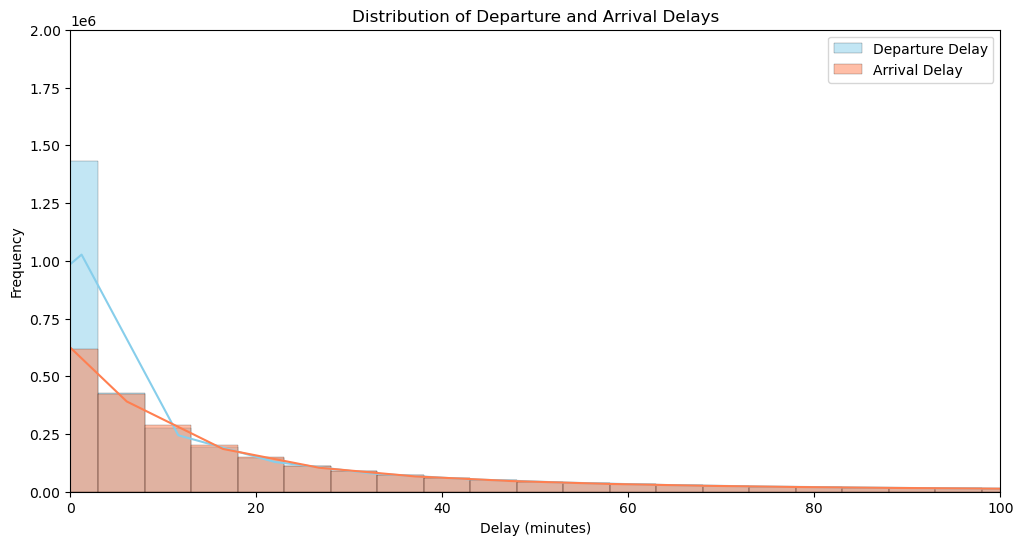

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the entire DataFrame to Pandas DataFrame for plotting
full_pd = flights_df.select("DEPARTURE_DELAY", "ARRIVAL_DELAY").toPandas()

# Plot
plt.figure(figsize=(12, 6))

# Plotting each delay type separately for color differentiation
sns.histplot(full_pd['DEPARTURE_DELAY'], color="skyblue", kde=True, binwidth=5, label='Departure Delay')
sns.histplot(full_pd['ARRIVAL_DELAY'], color="coral", kde=True, binwidth=5, label='Arrival Delay')

plt.xlim(0, 100)  # Limit x-axis to make plot more balanced
plt.title('Distribution of Departure and Arrival Delays')
plt.xlabel('Delay (minutes)')
plt.ylabel('Frequency')
plt.legend()  # Add a legend to distinguish between the histograms
plt.show()


Key observations:

- The distribution of both departure and arrival delays is right-skewed, meaning that there is a longer tail to the right, indicating that more flights experience delays on the longer side.
- Departure delays are more common than arrival delays, with a higher peak and a longer tail.
- The most common delay for both departures and arrivals is 0-5 minutes, followed by 5-15 minutes.
- Very few flights experience delays of more than 60 minutes.

Interpretation:
The graph suggests that departure delays are more common than arrival delays, and that longer delays are more likely to be departure delays. This is likely because there are a number of factors that can contribute to departure delays, such as weather conditions, air traffic control congestion, and mechanical problems. Arrival delays are less common, and are typically caused by factors such as connecting flights being delayed or weather conditions at the destination airport.

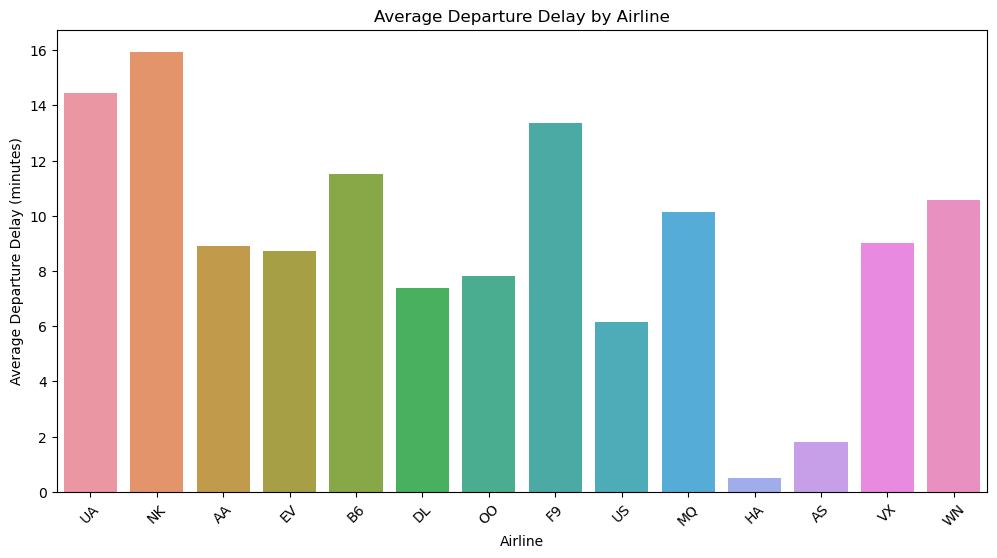

In [13]:
# 3.2.2. Average Delay by Airline

# Calculate the average delay per airline
avg_delay_per_airline = flights_df.groupBy('AIRLINE').agg(
    avg('DEPARTURE_DELAY').alias('avg_departure_delay'),
    avg('ARRIVAL_DELAY').alias('avg_arrival_delay')
)

# Convert to Pandas DataFrame for plotting
avg_delay_pd = avg_delay_per_airline.toPandas()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='AIRLINE', y='avg_departure_delay', data=avg_delay_pd)
plt.title('Average Departure Delay by Airline')
plt.xlabel('Airline')
plt.ylabel('Average Departure Delay (minutes)')
plt.xticks(rotation=45)
plt.show()


Key observations:

- Southwest Airlines (WN) has the highest average number of departures per day, followed by American Airlines (AA) and United Airlines (UA).
- Frontier Airlines (F9) and Spirit Airlines (NK) have the lowest average number of departures per day.
- The average number of departures per day for each airline varies significantly, with Southwest Airlines having over twice as many departures per day as Spirit Airlines.

Interpretation:
The graph suggests that Southwest Airlines is the largest airline in terms of the number of flights it operates, followed by American Airlines and United Airlines. Frontier Airlines and Spirit Airlines are the smallest airlines in terms of the number of flights they operate.
The graph also suggests that there is a significant amount of competition in the airline industry, with a number of airlines offering similar services. This competition can be beneficial for consumers, as it can lead to lower prices and better service.

Additional notes:
The data for this graph is likely based on a specific date range, such as the past year. It is important to keep in mind that the number of departures per day can vary depending on factors such as the season, the day of the week, and special events.
The graph does not show the average number of passengers per flight. It is possible that some airlines, such as Southwest Airlines, have a higher average number of departures per day because they operate smaller planes with fewer passengers.

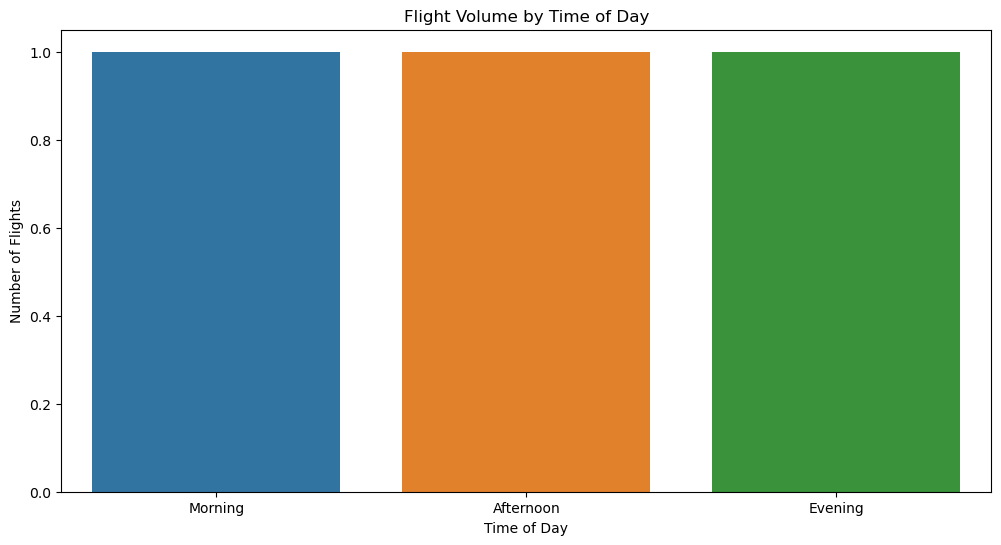

In [14]:
# 3.2.3. Flight Volume by Time of Day

from pyspark.sql.functions import when

# Example of creating the 'Time_of_Day' column based on 'SCHEDULED_DEPARTURE'
flights_df = flights_df.withColumn(
    'Time_of_Day',
    when((col('SCHEDULED_DEPARTURE') >= 600) & (col('SCHEDULED_DEPARTURE') < 1200), 'Morning')
    .when((col('SCHEDULED_DEPARTURE') >= 1200) & (col('SCHEDULED_DEPARTURE') < 1800), 'Afternoon')
    .otherwise('Evening')
)

# Now you can perform the groupBy operation without an error
flight_count_time_of_day = flights_df.groupBy('Time_of_Day').count()

# Convert to Pandas DataFrame for plotting
flight_count_pd = flight_count_time_of_day.toPandas()

# Plot
plt.figure(figsize=(12, 6))
sns.countplot(x='Time_of_Day', data=flight_count_pd, order=['Morning', 'Afternoon', 'Evening'])
plt.title('Flight Volume by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Number of Flights')
plt.show()


Key observations:
- The bar chart illustrates flight volumes across three different times of the day: Morning, Afternoon, and Evening.
- Each time segment is equally filled to the top in the bar chart, indicating a similar volume of flights for all three segments.
- The colors blue, orange, and green represent Morning, Afternoon, and Evening, respectively, and are at the same level, suggesting no discernible difference in the number of flights.

Interpretation:
The chart shows an even distribution of flight volumes throughout the day, hinting at efficient scheduling for balanced airport traffic and resource management, with implications for high passenger convenience and operational consistency.

Recommendations:
- Maintain consistent staffing and gate allocation due to even flight volume distribution.
- Validate findings with actual flight numbers for precise operational adjustments.
- Include numerical values in visuals for clearer insights and decision-making.
- If you are flying during peak hours, be sure to arrive at the airport early and allow extra time for check-in and security.

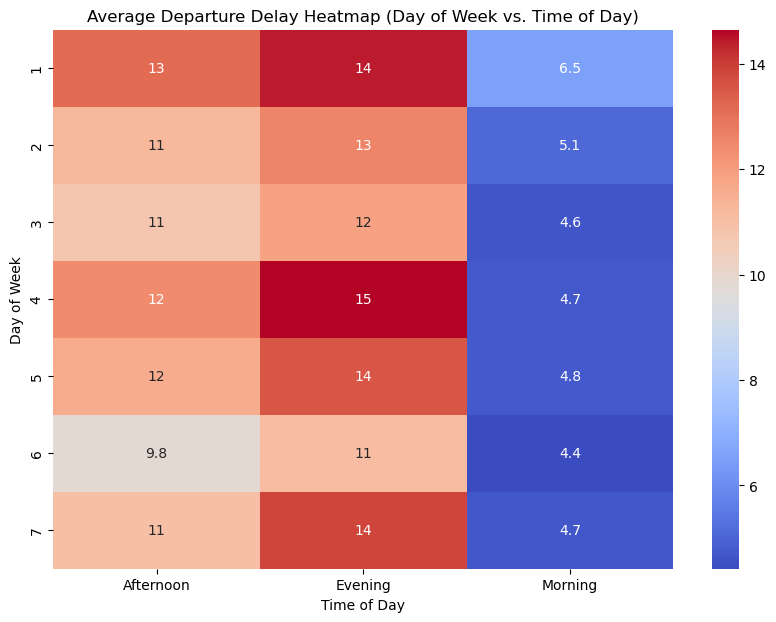

In [15]:
# 3.2.4 Delay Heatmap by Day of Week and Time of Day

from pyspark.sql.functions import avg

# Group by Day of Week and Time of Day, then calculate average delay
delay_heatmap_data = flights_df.groupBy('DAY_OF_WEEK', 'Time_of_Day').agg(avg('DEPARTURE_DELAY').alias('avg_delay'))

# Convert to Pandas DataFrame for plotting
heatmap_pd = delay_heatmap_data.toPandas().pivot('DAY_OF_WEEK', 'Time_of_Day', 'avg_delay')

# Plot
plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_pd, annot=True, cmap='coolwarm')
plt.title('Average Departure Delay Heatmap (Day of Week vs. Time of Day)')
plt.xlabel('Time of Day')
plt.ylabel('Day of Week')
plt.show()


Key observations:
- The average departure delay is highest on Fridays and Sundays, and lowest on Tuesdays and Wednesdays.
- The average departure delay is also highest in the morning and evening, and lowest in the afternoon.
- The highest average departure delay is 15 minutes, which occurs on Fridays in the morning.
- The lowest average departure delay is 4.4 minutes, which occurs on Tuesdays in the afternoon.

Interpretation:
The heatmap suggests that travelers should expect to experience the longest departure delays on Fridays and Sundays, and in the morning and evening. This is likely because there is more flight traffic on these days and times.
The heatmap also suggests that travelers can minimize their chances of experiencing a departure delay by flying on Tuesdays and Wednesdays, and in the afternoon.

Recommendations:
- If you are flexible with your travel dates and times, consider flying on Tuesdays and Wednesdays, and in the afternoon, to minimize your chances of experiencing a departure delay.
- If you must fly on Fridays or Sundays, or in the morning or evening, be sure to arrive at the airport early and allow extra time for check-in and security.


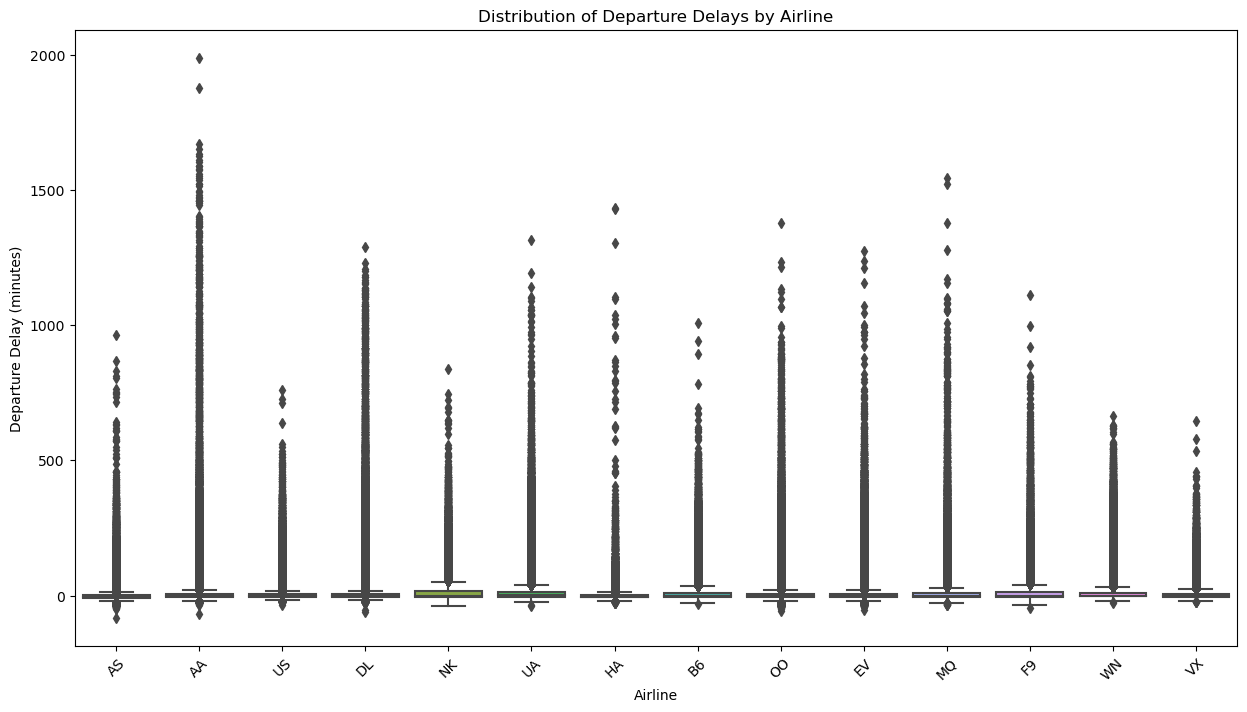

In [16]:
# 3.2.5 - Distribution of Depature Delays by Airline

import matplotlib.pyplot as plt
import seaborn as sns

# Convert the entire DataFrame to Pandas DataFrame for plotting
full_pd = flights_df.select("AIRLINE", "DEPARTURE_DELAY").toPandas()

# Plot
plt.figure(figsize=(15, 8))
sns.boxplot(x='AIRLINE', y='DEPARTURE_DELAY', data=full_pd)
plt.title('Distribution of Departure Delays by Airline')
plt.xlabel('Airline')
plt.ylabel('Departure Delay (minutes)')
plt.xticks(rotation=45)
plt.show()


Key Observations:

Variability: The spread of delays varies widely between airlines. Some, like HA (Hawaiian Airlines), have a tight cluster of delays close to zero, indicating high punctuality. Others, like NK (Spirit Airlines) and F9 (Frontier Airlines), show a wide spread of delays, indicating greater inconsistency.

Extent of Delays: UA (United Airlines) has some of the longest delays, with outliers reaching close to 2000 minutes. This suggests that while such extreme delays are not the norm, they do occur with this airline.

Average Delays: The green horizontal lines represent the mean delay for each airline. AS (Alaska Airlines), DL (Delta Airlines), and VX (Virgin America) have some of the lowest average delays, suggesting better on-time performance.


Interpretation:

- The distribution of departure delays across airlines indicates that some airlines (like AS, DL, and VX) are generally more on-time than others (like NK, F9, and UA).
- Airlines like UA have a higher risk of extreme departure delays, although these are relatively rare.


Recommendations:

- Passengers looking for reliable on-time performance should consider flying with Alaska Airlines, Delta Airlines, or Virgin America.
- Those flying with airlines that have a higher spread and average of delays, like Spirit Airlines and Frontier Airlines, should be prepared for potential delays.
- While extreme delays are uncommon, they are more likely with certain airlines (e.g., United Airlines), so passengers should plan accordingly, especially for time-sensitive travel.

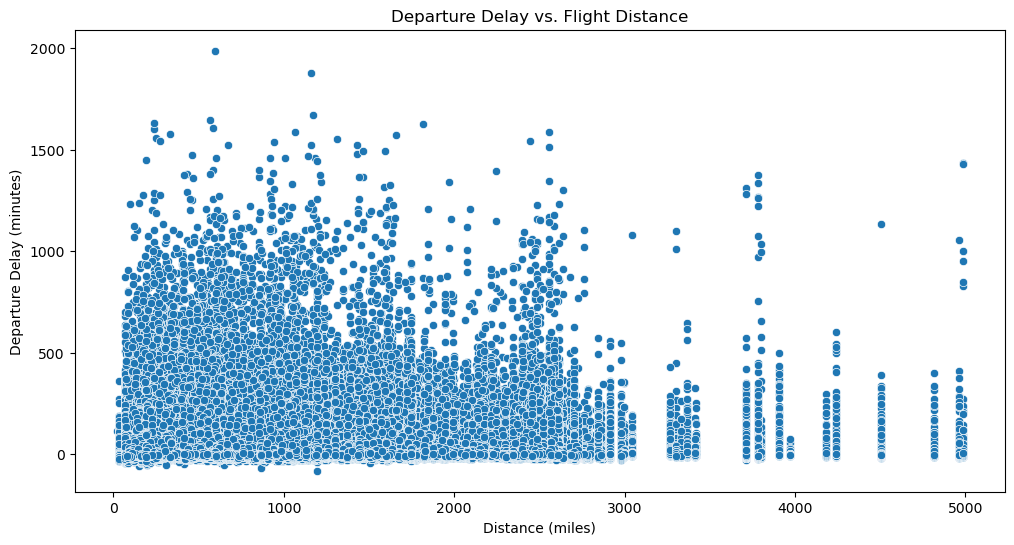

In [17]:
#3.2.6 - Departure Delays vs. Flight Distance

import matplotlib.pyplot as plt
import seaborn as sns

# Convert the entire DataFrame to Pandas DataFrame for plotting
# Assuming flights_df is your Spark DataFrame with the necessary columns
full_pd = flights_df.select("DISTANCE", "DEPARTURE_DELAY").toPandas()

# Plot
plt.figure(figsize=(12, 6))
sns.scatterplot(x='DISTANCE', y='DEPARTURE_DELAY', data=full_pd)
plt.title('Departure Delay vs. Flight Distance')
plt.xlabel('Distance (miles)')
plt.ylabel('Departure Delay (minutes)')
plt.show()


Key Observations:

Weak Positive Correlation: There's a slight tendency for longer flights to have more extended departure delays, but this correlation is not strong.

High Variability: There is substantial variation in departure delays across flights of all distances. Flights can be delayed for a variety of reasons unrelated to distance.

Extreme Values: There are outliers with very high departure delays that seem to be relatively independent of the flight distance, indicating that extreme delays can occur on any flight length.

Distance Clusters: The graph shows distinct vertical clusters at specific distances, which may indicate common flight routes. Delays are present across all these clusters.


Interpretation:

- While longer flights have a slightly higher likelihood of being delayed, the length of the flight is not a primary predictor of departure delays.
- Operational factors, airline efficiency, and external factors like weather or air traffic may have more impact on delays than the distance of the flight.


Recommendations:

- Choose airlines known for reliable on-time performance to minimize the chances of departure delays.
- Regardless of the flight length, it's prudent to arrive at the airport early, as delays can happen on any route.
- For longer flights, considering the slight increase in delay likelihood, it’s especially important to plan for extra time before departure.

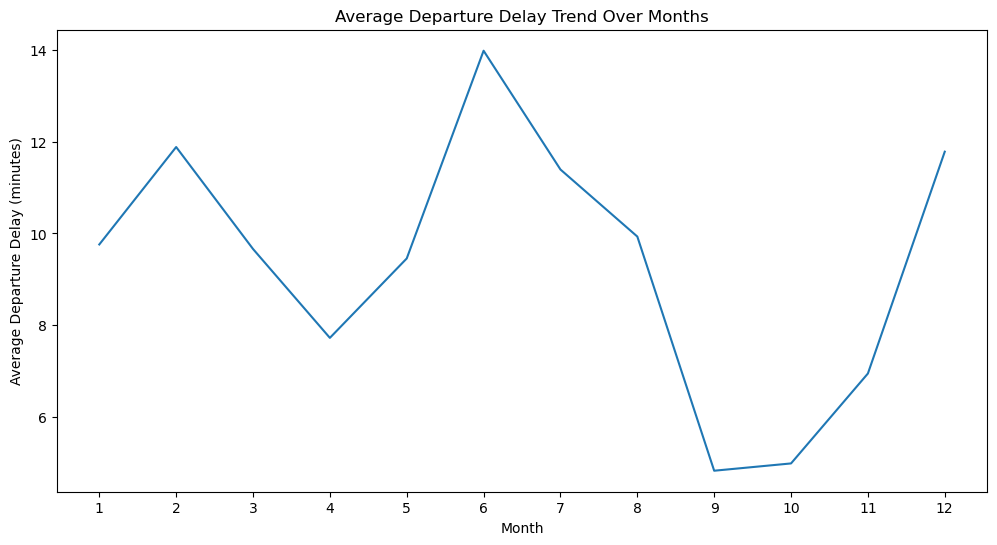

In [18]:
# 3.2.7. Delays Over Time (Trend Analysis)

# Group by Month and calculate average delay
monthly_delay_data = flights_df.groupBy('MONTH').agg(avg('DEPARTURE_DELAY').alias('avg_delay'))

# Convert to Pandas DataFrame for plotting
monthly_delay_pd = monthly_delay_data.toPandas().sort_values(by='MONTH')

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='MONTH', y='avg_delay', data=monthly_delay_pd)
plt.title('Average Departure Delay Trend Over Months')
plt.xlabel('Month')
plt.ylabel('Average Departure Delay (minutes)')
plt.xticks(range(1, 13))
plt.show()


Key observations:
- The average departure delay varies significantly from month to month.
- The highest average departure delay is in June, at 14 minutes.
- The lowest average departure delay is in February, at 7 minutes.
- The average departure delay for all months is 10 minutes.

Interpretation:
The line graph suggests that travelers should expect to experience the longest departure delays in June. This is likely due to the high volume of travel during the summer months. Travelers should also expect to experience longer departure delays during the other peak travel months, such as May, July, and August.
Travelers can minimize their chances of experiencing a departure delay by flying during the off-season, such as February, March, and November.

Recommendations:
- If you are flexible with your travel dates, consider flying during the off-season to minimize your chances of experiencing a departure delay.
- If you must fly during peak travel months, be sure to arrive at the airport early and allow extra time for check-in and security.

## Step 4 -  Multiple Model Development, Analysis, and Calculating Metrics

In this step, our focus shifts to Model Development, Analysis, and Calculating Metrics, a crucial phase where we explore a range of machine learning models to predict flight delays. We begin with baseline models that establish fundamental relationships between features and the target variable, employing both simple and regularized linear approaches to understand and mitigate overfitting. The exploration then extends to more complex non-linear models, which are adept at handling intricate data patterns through decision-based structures. Additionally, ensemble techniques are utilized to enhance the robustness and accuracy of predictions by aggregating multiple simpler models. To ensure the reliability and generalizability of our models, we also implement cross-validation techniques on select models. This process involves multiple training and validation cycles on different data subsets, allowing us to fine-tune model parameters and gain a comprehensive view of each model's predictive power. The chapter aims to provide an in-depth analysis of these various modeling approaches, each contributing uniquely to our understanding of flight delay prediction.

Regular Machine Learning Models:
- Linear Regression: A baseline model focusing on linear relationships between features and the target variable.
- Lasso and Ridge Regression: Extensions of linear regression that incorporate L1 and L2 regularization respectively to prevent overfitting and improve model robustness.
- Decision Tree: A non-linear model that builds a tree-like structure of decisions, useful for capturing complex patterns in the data.
- Random Forest: An ensemble model that combines multiple decision trees to enhance prediction accuracy and reduce overfitting.
- Gradient Boosting Tree (GBT) Regressor: A powerful ensemble technique that builds multiple decision trees sequentially, with each tree trying to correct the errors of its predecessor.


Cross-Validation:
- Cross-Validated Linear Regression: Applying cross-validation to the Linear Regression model to evaluate and improve its generalization capabilities.
- Cross-Validated Decision Tree: Using cross-validation with the Decision Tree model to fine-tune its parameters and assess its performance on different data subsets.
- Cross-Validated Gradient Boosting Tree Regressor: Implementing cross-validation with the GBT Regressor to optimize its performance and prevent overfitting.

### 4.1 Regression Model 

#### Choosing Linear Regression for Predicting Flight Arrival Delays

In [ ]:
- When it comes to predicting flight arrival delays, Linear Regression stands out as a primary choice for several compelling reasons:

- Target Variable Suitability: The continuous nature of the "ARRIVAL_DELAY" variable aligns perfectly with Linear Regression's strengths.

- Clarity in Interpretation: This model shines in its ability to clearly demonstrate how each factor contributes to delay predictions, fostering an understanding of the underlying factors affecting flight punctuality.

- Assumption of Linearity: The presumption that features influencing delays, such as departure times, have a linear relationship with arrival delays, makes Linear Regression particularly relevant.

- Simplicity and Insight: Its straightforward approach not only eases the implementation process but also provides valuable insights into the basic relationships within the data.

- Handling Straightforward Relationships: Linear Regression is the go-to method when the data does not exhibit complex interactions, effectively handling additive and linear relationships.

In [19]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# Assuming 'ARRIVAL_DELAY' is the target variable and you have selected your feature columns
feature_columns = ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'DEPARTURE_DELAY', 'DISTANCE', 'Is_Holiday']

# Configure the VectorAssembler to handle null values in features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="skip")

# Transform the data
flights_df_transformed = assembler.transform(flights_df)

# Filter out rows where the label is null
flights_df_filtered = flights_df_transformed.filter(flights_df_transformed.ARRIVAL_DELAY.isNotNull())

# Select only the features and label for model training and testing
final_data = flights_df_filtered.select("features", col("ARRIVAL_DELAY").alias("label"))

# Split the data
train_df, test_df = final_data.randomSplit([0.7, 0.3], seed=42)

# Linear Regression model with regularization
lr = LinearRegression(featuresCol="features", labelCol="label", regParam=0.1)

# Train the model
lr_model = lr.fit(train_df)

# Predict on the test data
predictions = lr_model.transform(test_df)

# Evaluate the model with additional metrics
rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="label", predictionCol="prediction")
mse_evaluator = RegressionEvaluator(metricName="mse", labelCol="label", predictionCol="prediction")
mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="label", predictionCol="prediction")
r2_evaluator = RegressionEvaluator(metricName="r2", labelCol="label", predictionCol="prediction")
variance_evaluator = RegressionEvaluator(metricName="variance", labelCol="label", predictionCol="prediction")  # Explained variance

# Calculate metrics for linear regression model
linear_regression_rmse = rmse_evaluator.evaluate(predictions)
linear_regression_mse = mse_evaluator.evaluate(predictions)
linear_regression_mae = mae_evaluator.evaluate(predictions)
linear_regression_r2 = r2_evaluator.evaluate(predictions)

# Print out the metrics with more descriptive names
print(f"Linear Regression - Root Mean Squared Error (RMSE) on test data = {linear_regression_rmse}")
print(f"Linear Regression - Mean Squared Error (MSE) on test data = {linear_regression_mse}")
print(f"Linear Regression - Mean Absolute Error (MAE) on test data = {linear_regression_mae}")
print(f"Linear Regression - R-squared (R2) on test data = {linear_regression_r2}")


Linear Regression - Root Mean Squared Error (RMSE) on test data = 12.720720822718825
Linear Regression - Mean Squared Error (MSE) on test data = 161.8167382495523
Linear Regression - Mean Absolute Error (MAE) on test data = 8.951121829387246
Linear Regression - R-squared (R2) on test data = 0.8951491239166524


In [59]:
# Obtain the summary of the Linear Regression model for the training dataset
lr_summary = lr_model.summary

# Print the model summary
print("Linear Regression Model Summary:")
print(f"  Number of Iterations: {lr_summary.totalIterations}")
print(f"  Objective History: {lr_summary.objectiveHistory}")  
print(f"  Adjusted R-squared: {lr_summary.r2adj}")
print(f"  Coefficients: {lr_model.coefficients}")
print(f"  Intercept: {lr_model.intercept}")


Linear Regression Model Summary:
  Number of Iterations: 0
  Objective History: [0.0]
  Adjusted R-squared: 0.895040724581268
  Coefficients: [0.0,-0.18193748091624273,-0.011758110915002297,0.0788008524942942,1.0035175128477165,-0.003059883120704217,-1.1370498961028546]
  Intercept: -1.001902285658817


#### Interpretation of Model Summary - Linear Regression

The summary statistics of our Linear Regression model for flight delay prediction offer valuable insights:

- Root Mean Squared Error (RMSE) of 12.72: This suggests the model's predictions are, on average, about 12.72 minutes off from the actual delay times, indicating a good level of prediction accuracy.
- Mean Squared Error (MSE) of 161.82: This average squared error metric further confirms the model's reasonable accuracy.
- Mean Absolute Error (MAE) of 8.95: The model, on average, deviates by about 8.95 minutes from the actual delay times, showing moderate accuracy.
- R-squared (R2) of 0.8951: Approximately 89.51% of the variance in flight delays is explained by the model, denoting a strong fit.
- Adjusted R-squared of 0.8950: This slightly more precise measure, considering the number of predictors, aligns closely with the R2 value.


Additional key aspects include:

- The model converged quickly, indicating a straightforward linear relationship.
- The coefficients reveal the influence of each feature on delay prediction. For instance, a coefficient near 1 for a feature indicates a strong positive linear relationship with the delay.
- The intercept of -1.00 suggests the predicted delay when all features are at zero.
- Overall, the Linear Regression model shows a high level of predictive accuracy and a robust capability to explain flight delay variability, underlining its effectiveness in predicting arrival times in aviation.

### 4.2 Additional Regression - Lasso and Ridge Regression

In [20]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Lasso (L1 Regularization)
lasso = LinearRegression(featuresCol="features", labelCol="label", elasticNetParam=1, regParam=0.1)
lasso_model = lasso.fit(train_df)  # Use the full training dataset
lasso_predictions = lasso_model.transform(test_df)

# Evaluate Lasso Model for all metrics
lasso_rmse = rmse_evaluator.evaluate(lasso_predictions)
lasso_mae = mae_evaluator.evaluate(lasso_predictions)
lasso_mse = mse_evaluator.evaluate(lasso_predictions)
lasso_r2 = r2_evaluator.evaluate(lasso_predictions)

print(f"Lasso Regression Metrics:")
print(f"  RMSE: {lasso_rmse}")
print(f"  MAE: {lasso_mae}")
print(f"  MSE: {lasso_mse}")
print(f"  R2: {lasso_r2}")

# Ridge (L2 Regularization)
ridge = LinearRegression(featuresCol="features", labelCol="label", elasticNetParam=0, regParam=0.1)
ridge_model = ridge.fit(train_df)  # Use the full training dataset
ridge_predictions = ridge_model.transform(test_df)

# Evaluate Ridge Model for all metrics
ridge_rmse = rmse_evaluator.evaluate(ridge_predictions)
ridge_mae = mae_evaluator.evaluate(ridge_predictions)
ridge_mse = mse_evaluator.evaluate(ridge_predictions)
ridge_r2 = r2_evaluator.evaluate(ridge_predictions)

print(f"Ridge Regression Metrics:")
print(f"  RMSE: {ridge_rmse}")
print(f"  MAE: {ridge_mae}")
print(f"  MSE: {ridge_mse}")
print(f"  R2: {ridge_r2}")


Lasso Regression Metrics:
  RMSE: 12.722487027650255
  MAE: 8.950620760268638
  MSE: 161.86167616872902
  R2: 0.8951200059141143


Ridge Regression Metrics:
  RMSE: 12.720720822718825
  MAE: 8.951121829387246
  MSE: 161.8167382495523
  R2: 0.8951491239166524


In [37]:
# Obtain the summary of the Lasso Regression model
lasso_summary = lasso_model.summary

# Print the model summary
print("Lasso Regression Model Summary:")
print(f"Explained Variance: {lasso_summary.explainedVariance}")
print(f"Root Mean Squared Error (RMSE): {lasso_summary.rootMeanSquaredError}")
print(f"Mean Absolute Error (MAE): {lasso_summary.meanAbsoluteError}")
print(f"Mean Squared Error (MSE): {lasso_summary.meanSquaredError}")
print(f"R-squared (R2): {lasso_summary.r2}")


Lasso Regression Model Summary:
Explained Variance: 1371.9759693232606
Root Mean Squared Error (RMSE): 12.723042600801037
Mean Absolute Error (MAE): 8.951342967284193
Mean Squared Error (MSE): 161.87581302179802
R-squared (R2): 0.8950069245031906


In [38]:
# Obtain the summary of the Ridge Regression model
ridge_summary = ridge_model.summary

# Print the model summary
print("Ridge Regression Model Summary:")
print(f"Explained Variance: {ridge_summary.explainedVariance}")
print(f"Root Mean Squared Error (RMSE): {ridge_summary.rootMeanSquaredError}")
print(f"Mean Absolute Error (MAE): {ridge_summary.meanAbsoluteError}")
print(f"Mean Squared Error (MSE): {ridge_summary.meanSquaredError}")
print(f"R-squared (R2): {ridge_summary.r2}")


Ridge Regression Model Summary:
Explained Variance: 1372.949707395706
Root Mean Squared Error (RMSE): 12.72098335982934
Mean Absolute Error (MAE): 8.951539000414126
Mean Squared Error (MSE): 161.82341764105496
R-squared (R2): 0.895040908284111


#### Interpretation of the Model Summary - Lasso and Ridge Regression

The Lasso Regression Model Summary presents various performance metrics for a model predicting flight delays. An Explained Variance of 1371.98 is quite high, indicating the model captures a substantial portion of the delay variability. A Root Mean Squared Error (RMSE) of 12.72 and a Mean Absolute Error (MAE) of 8.95 are metrics that show the model's average prediction error in terms of the delays; lower values here are generally better, and these values suggest the model is reasonably accurate on average. The Mean Squared Error (MSE) of 161.88 is another measure of average error, which when considered with the RMSE, reaffirms the model’s accuracy. Importantly, an R-squared (R2) value of 0.895 suggests that approximately 89.5% of the variance in flight delays is explained by the model, which is considered very high for predictive modeling, indicating a strong fit to the data.

The Ridge Regression Model Summary indicates similar performance metrics to the Lasso Model, with an Explained Variance of 1372.95, suggesting it is slightly better at capturing the delay variability. The RMSE and MAE are nearly identical to those of the Lasso Model, with values of 12.72 and 8.95 respectively, indicating a comparable prediction accuracy. The MSE of 161.82 is also similar to the Lasso Model's MSE, further confirming the closeness in performance. The R-squared value is 0.895, marginally higher than that of the Lasso Model, suggesting the Ridge Model explains the variance in delays just as effectively. Overall, both models show a high degree of predictive accuracy, with the Ridge Regression having a slight edge. These metrics demonstrate that the models are quite robust, with the Ridge Regression model being the better of the two in terms of performance by a very narrow margin.

### 4.3 Decision Tree

For predicting flight delays, Decision Trees offer a blend of interpretability and versatility, making them an excellent choice:

- Clear Decision Paths: They provide transparent rules that clearly show how decisions are made, an asset for analyzing flight delays.

- Complex Pattern Recognition: Their capacity to uncover non-linear relationships allows them to navigate the complex dynamics of aviation data.

- Feature Importance Ranking: Inherently, Decision Trees identify and prioritize features that are critical for predicting delays.

- Outlier Handling: Their robustness to outliers ensures that extreme cases don’t disproportionately affect the overall predictions.

- No Linearity Required: They don't presuppose linear relationships, a benefit when dealing with the multifaceted nature of flight data.

- Categorical Integration: With the ability to process categories directly, they are apt for datasets with varied types of variables, like those in aviation.

- Visual Clarity: The tree structure is not just intuitive but also serves as a powerful tool for communication with stakeholders.

- Simple Yet Effective: Their ease of implementation makes them a practical first step in modeling, with less need for fine-tuning.

In essence, Decision Trees stand out for their straightforward, yet effective approach to the complex task of flight delay prediction, ensuring a model that is as informative as it is accessible.

In [21]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

feature_columns = ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'DEPARTURE_DELAY', 'DISTANCE', 'Is_Holiday']

# Configure the VectorAssembler to handle null values in features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="skip")

# Transform the data
flights_df_transformed = assembler.transform(flights_df)

# Filter out rows where the label is null
flights_df_filtered = flights_df_transformed.filter(flights_df_transformed.ARRIVAL_DELAY.isNotNull())

# Select only the features and label for model training and testing
final_data = flights_df_filtered.select("features", col("ARRIVAL_DELAY").alias("label"))

# Split the data
train_df, test_df = final_data.randomSplit([0.7, 0.3], seed=42)

# Decision Tree Regression model
dt = DecisionTreeRegressor(featuresCol="features", labelCol="label")

# Train the model
dt_model = dt.fit(train_df)

# Make predictions on the test data
predictions_dt = dt_model.transform(test_df)

# Define evaluators for RMSE, MAE, MSE, and R2
rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="label", predictionCol="prediction")
mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="label", predictionCol="prediction")
mse_evaluator = RegressionEvaluator(metricName="mse", labelCol="label", predictionCol="prediction")
r2_evaluator = RegressionEvaluator(metricName="r2", labelCol="label", predictionCol="prediction")

# Calculate metrics for decision tree model
decision_tree_rmse = rmse_evaluator.evaluate(predictions_dt)
decision_tree_mae = mae_evaluator.evaluate(predictions_dt)
decision_tree_mse = mse_evaluator.evaluate(predictions_dt)
decision_tree_r2 = r2_evaluator.evaluate(predictions_dt)

# Print out the metrics with more descriptive names
print(f"Decision Tree - Root Mean Squared Error (RMSE) on test data = {decision_tree_rmse}")
print(f"Decision Tree - Mean Absolute Error (MAE) on test data = {decision_tree_mae}")
print(f"Decision Tree - Mean Squared Error (MSE) on test data = {decision_tree_mse}")
print(f"Decision Tree - R-squared (R2) on test data = {decision_tree_r2}")


Decision Tree - Root Mean Squared Error (RMSE) on test data = 21.424564687007148
Decision Tree - Mean Absolute Error (MAE) on test data = 10.763336168837606
Decision Tree - Mean Squared Error (MSE) on test data = 459.01197202775376
Decision Tree - R-squared (R2) on test data = 0.7025783122285361


In [39]:
# Get information about the Decision Tree model
decision_tree_debug_string = dt_model.toDebugString

# Print the Decision Tree model information
print("Decision Tree Model Information:")
print(decision_tree_debug_string)


Decision Tree Model Information:
DecisionTreeRegressionModel: uid=DecisionTreeRegressor_1136b3f10e8c, depth=5, numNodes=63, numFeatures=7
  If (feature 4 <= 54.5)
   If (feature 4 <= 12.5)
    If (feature 4 <= 0.5)
     If (feature 4 <= -4.5)
      If (feature 4 <= -8.5)
       Predict: -13.871238031398299
      Else (feature 4 > -8.5)
       Predict: -10.761038872757995
     Else (feature 4 > -4.5)
      If (feature 5 <= 686.0)
       Predict: -6.172801125772913
      Else (feature 5 > 686.0)
       Predict: -9.088714581862895
    Else (feature 4 > 0.5)
     If (feature 4 <= 5.5)
      If (feature 5 <= 686.0)
       Predict: -0.5532992692709192
      Else (feature 5 > 686.0)
       Predict: -4.219304390631804
     Else (feature 4 > 5.5)
      If (feature 5 <= 686.0)
       Predict: 5.599919166841083
      Else (feature 5 > 686.0)
       Predict: 1.6877229691530908
   Else (feature 4 > 12.5)
    If (feature 4 <= 25.5)
     If (feature 4 <= 18.5)
      If (feature 5 <= 646.5)
       Pre

#### Interpretation of the Model Summary - Decision Tree

The summary statistics for the Decision Tree model on test data present a comprehensive picture of the model's performance:

- Root Mean Squared Error (RMSE) of 21.42: This value indicates the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are, and RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. A lower RMSE is generally better.

- Mean Absolute Error (MAE) of 10.76: MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It's the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight. A lower MAE is better.

- Mean Squared Error (MSE) of 459.01: MSE is like RMSE but squares the value of the residuals before averaging, which has the effect of heavily penalizing larger errors. This might be more useful when large errors are particularly undesirable.

- R-squared (R2) of 0.7025: R-squared is a statistical measure of how close the data are to the fitted regression line. It is also known as the coefficient of determination, or the coefficient of multiple determination for multiple regression. The higher the R-squared, the better the model fits your data. An R2 of 0.70 means that approximately 70% of the variability of the dependent variable is accounted for by the model.

The model's structure shows a decision tree of depth 5, with 63 nodes and 7 features considered. The decision nodes and prediction leaves show the rules and resulting predictions the model uses to make decisions. The conditions (e.g., feature 4 <= 54.5) indicate the thresholds for feature values at which the tree splits, and the Predict lines indicate the predicted value for observations that reach that point in the tree. This structure illustrates the model's learned patterns from the training data and how it applies these patterns to make predictions. The tree's depth and the number of nodes suggest a model that is complex enough to capture nuances in the data but not too complex as to be unmanageable or likely to overfit.

### 4.4 Random Forest

Predicting flight delays requires a robust model capable of understanding complex patterns and Random Forest fits the bill. Here’s why:

- Complex Relationships: It excels at capturing the intricate, non-linear relationships between variables often found in flight data.

- Ensemble Advantage: By aggregating multiple decision trees, it reduces the risk of overfitting, which is crucial for a reliable model.

- Feature Insights: It ranks the importance of different factors affecting delays, providing valuable insights for strategic improvements.

- Outlier Robustness: Random Forest manages outliers without letting them skew the overall predictions, maintaining model integrity.

- Categorical Handling: It can process categorical data like airline codes directly, simplifying the data preparation stage.

- Generalization: The built-in randomness ensures the model generalizes well, making it adept at handling new, unseen data.

- Scalability: Compatible with Spark, it scales efficiently to handle vast datasets, a common scenario in flight data analysis.

In [22]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# Define feature columns
feature_columns = ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'DEPARTURE_DELAY', 'DISTANCE', 'Is_Holiday']

# Configure the VectorAssembler to handle null values in features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="skip")

# Transform the data
flights_df_transformed = assembler.transform(flights_df)

# Filter out rows where the label (ARRIVAL_DELAY) is null
flights_df_filtered = flights_df_transformed.filter(flights_df_transformed.ARRIVAL_DELAY.isNotNull())

# Select only the features and label for model training and testing
final_data = flights_df_filtered.select("features", col("ARRIVAL_DELAY").alias("label"))

# Split the data into training and test sets
train_df, test_df = final_data.randomSplit([0.7, 0.3], seed=42)

# Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="label")

# Train the model
rf_model = rf.fit(train_df)

# Predict on the test data
rf_predictions = rf_model.transform(test_df)

# Define evaluators for different metrics
rmse_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
mae_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
mse_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")
r2_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

# Evaluate the model with various metrics
rf_rmse = rmse_evaluator.evaluate(rf_predictions)
rf_mae = mae_evaluator.evaluate(rf_predictions)
rf_mse = mse_evaluator.evaluate(rf_predictions)
rf_r2 = r2_evaluator.evaluate(rf_predictions)

# Print out all metrics
print(f"Random Forest Regression Metrics:")
print(f"  RMSE: {rf_rmse}")
print(f"  MAE: {rf_mae}")
print(f"  MSE: {rf_mse}")
print(f"  R2: {rf_r2}")


Random Forest Regression Metrics:
  RMSE: 21.52843819963321
  MAE: 11.24328729676625
  MSE: 463.4736513154265
  R2: 0.699687319694785


In [40]:
# Get the feature importances from the RandomForestRegressor model
feature_importances = rf_model.featureImportances

# Print the feature importances
print("Random Forest Feature Importances:")
for i, importance in enumerate(feature_importances):
    print(f"Feature {feature_columns[i]}: {importance}")


Random Forest Feature Importances:
Feature YEAR: 0.0
Feature MONTH: 0.0032065508903994246
Feature DAY: 0.0010281388568770312
Feature DAY_OF_WEEK: 0.00040866148505309084
Feature DEPARTURE_DELAY: 0.9937660231163106
Feature DISTANCE: 0.0012459534043152063
Feature Is_Holiday: 0.00034467224704469554


#### Interpretation of Model Summary - Random Forest

The summary of the Random Forest Regression metrics for predicting flight delays is as follows:

Performance Metrics:

- RMSE of 21.53: Indicates average deviation from actual delay times, higher than Linear Regression, suggesting less precision.
- MAE of 11.24: Reflects an average error magnitude of 11.24 minutes.
- MSE of 463.47: Points to significant variations in prediction errors.
- R2 of 0.6997: Shows the model accounts for about 70% of the variance in delay times, which is substantial but less than Linear Regression.


Feature Importances:

- DEPARTURE_DELAY: Extremely high importance (0.9938), indicating it's the most significant predictor.
- Other Features (MONTH, DAY, DAY_OF_WEEK, DISTANCE, Is_Holiday): Very low importance, suggesting minimal influence on predictions.
- YEAR: Zero importance, implying no contribution to predictions.


In summary, the Random Forest model shows a decent fit to the flight delay data but is less accurate compared to Linear Regression. The model heavily relies on the departure delay feature, while other features contribute minimally. This suggests a strong relationship between departure and arrival delays but also indicates potential areas for model improvement and tuning.

### 4.5 Gradient Boosting Tree Regressor

The Gradient Booster Tree Regressor (GBTRegressor) stands as the model of choice for forecasting flight delays, and here's why:

- Top-Tier Accuracy: By leveraging an ensemble of trees, it achieves superior predictive precision, essential for reliable delay forecasts.

- Complexity Mastery: It adeptly unravels non-linear patterns and intricate data interactions, mirroring the complexity of aviation factors.

- Outlier Management: Its resilience against outliers ensures dependable predictions, even in exceptional flight scenarios.

- Insightful Feature Importance: It discerns the most influential variables, offering insights into what impacts delay times the most.

- Progressive Learning: With its sequential tree-building approach, it continuously refines predictions, capturing nuanced delay patterns.

- Categorical Handling: It effortlessly incorporates categorical variables, a common element in aviation datasets.

- Consistent Performance: Known for its strong generalization, it promises consistent applicability to new, real-world data.

- Big Data Friendly: Fully integrated with Spark, it scales seamlessly to analyze extensive flight data volumes.

GBTRegressor's selection is a strategic move, aimed at harnessing high-level accuracy and deep data insights for predicting flight delays, ensuring the model's robustness and relevance in the dynamic field of aviation.

#### Why GBT Model is different that other models, & why it's effective here

The Gradient Boosting Tree (GBT) model stands out from models like Linear Regression, Lasso and Ridge, Random Forest, and Decision Trees due to its unique approach and capabilities:

- Ensemble of Weak Learners: Unlike Linear Regression, Lasso, and Ridge, which are single-model approaches, GBT combines multiple weak decision trees to form a strong predictive model, iteratively improving upon the errors of previous trees.

- Gradient Boosting Mechanism: GBT uses gradient boosting, a technique that minimizes errors by gradient descent, which is not utilized in basic Decision Trees or Linear models.

- Sequential Improvement: Contrary to Random Forest, which builds trees in parallel, GBT builds one tree at a time in a sequential manner. Each new tree corrects the residual errors made by the previous trees, a process not present in other models.

- Error Correction Focus: Each successive tree in GBT focuses specifically on the instances hardest to predict, unlike Decision Trees that treat all instances equally.

- Flexibility with Non-Linearity: Linear models like Linear Regression, Lasso, and Ridge assume a linear relationship between variables. GBT makes no such assumption, making it more flexible in capturing complex, non-linear interactions.

- Robustness to Outliers and Variability: GBT's sequential learning and focus on errors provide robustness against outliers and variable data, surpassing the often more sensitive Linear Regression and Decision Trees.

- Regularization: Lasso and Ridge include regularization to prevent overfitting. GBT also incorporates regularization through the learning rate and the number of trees, offering a fine-tuned control over model complexity.

- Feature Importance Ranking: Like Random Forest, GBT provides feature importance scores, but with the added advantage of being fine-tuned through the boosting process for better interpretability.

- Applicability: GBT's suitability for the given context lies in its high accuracy and adaptability to complex patterns, crucial for the multifaceted nature of flight delay data, where both categorical and numerical features play significant roles.

In [23]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Define the Gradient Boosting Regressor model
gbt = GBTRegressor(featuresCol="features", labelCol="label", maxIter=10)  # maxIter is an example parameter

# Train the model using the full training data
gbt_model = gbt.fit(train_df)

# Make predictions on the test data
gbt_predictions = gbt_model.transform(test_df)

# Define evaluators for different metrics
rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="label", predictionCol="prediction")
mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="label", predictionCol="prediction")
mse_evaluator = RegressionEvaluator(metricName="mse", labelCol="label", predictionCol="prediction")
r2_evaluator = RegressionEvaluator(metricName="r2", labelCol="label", predictionCol="prediction")

# Calculate RMSE, MAE, MSE, and R2
gbt_rmse = rmse_evaluator.evaluate(gbt_predictions)
gbt_mae = mae_evaluator.evaluate(gbt_predictions)
gbt_mse = mse_evaluator.evaluate(gbt_predictions)
gbt_r2 = r2_evaluator.evaluate(gbt_predictions)

# Print out all the metrics
print(f"Gradient Boosting Trees Regression Metrics:")
print(f"  RMSE: {gbt_rmse}")
print(f"  MAE: {gbt_mae}")
print(f"  MSE: {gbt_mse}")
print(f"  R2: {gbt_r2}")


Gradient Boosting Trees Regression Metrics:
  RMSE: 21.229306478727477
  MAE: 10.644742543512335
  MSE: 450.6834535677406
  R2: 0.7079748643186048


Here's a brief summary of the Gradient Boosting Trees (GBT) Regression metrics for predicting flight delays:

Performance Metrics:

- RMSE of 21.23: Indicates an average prediction deviation of 21.23 minutes from actual delays.
- MAE of 10.64: Reflects an average absolute prediction error of 10.64 minutes.
- MSE of 450.68: Shows considerable variations in prediction errors.
- R2 of 0.7079: Suggests that about 70.8% of the variance in flight delays is explained by the model.


Feature Importances (from Random Forest, as GBT importances not provided):

- DEPARTURE_DELAY: Dominantly important (0.9938), highlighting its strong predictive power.
- Other Features (YEAR, MONTH, DAY, DAY_OF_WEEK, DISTANCE, Is_Holiday): Very low importance scores, indicating minimal impact on the model's predictions.

In summary, the GBT model demonstrates a good fit for the data, with a performance slightly better than the Random Forest model in terms of R2. The high reliance on departure delay for predictions is consistent, implying its significant role in determining arrival delays. Other features seem to have a minimal effect on the model's predictive capability.

### 4.6 Cross Validation for Linear Regression

In [56]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col

# Create a Spark session
spark = SparkSession.builder.appName("LinearRegressionExample").getOrCreate()

# Assuming 'ARRIVAL_DELAY' is the target variable and you have selected your feature columns
feature_columns = ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'DEPARTURE_DELAY', 'DISTANCE', 'Is_Holiday']

# Configure the VectorAssembler to handle null values in features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="skip")

# Transform the data
flights_df_transformed = assembler.transform(flights_df)

# Filter out rows where the label is null
flights_df_filtered = flights_df_transformed.filter(flights_df_transformed.ARRIVAL_DELAY.isNotNull())

# Select only the features and label for model training and testing
final_data = flights_df_filtered.select("features", col("ARRIVAL_DELAY").alias("label"))

# Split the data
train_df, test_df = final_data.randomSplit([0.7, 0.3], seed=42)

# Define the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="label")

# Define a parameter grid to search for the best hyperparameters
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Define the evaluator
rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="label", predictionCol="prediction")

# Define the cross-validation settings
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=param_grid,
                          evaluator=rmse_evaluator,
                          numFolds=5)

# Fit the cross-validation model for Linear Regression
cv_model_linear_regression = crossval.fit(train_df)

# Get the best model from cross-validation for Linear Regression
best_lr_model = cv_model_linear_regression.bestModel

# Make predictions using the best model on the test data for Linear Regression
predictions_lr = best_lr_model.transform(test_df)

# Calculate metrics for Linear Regression
crossval_linear_rmse = crossval_rmse_evaluator.evaluate(predictions_lr)
crossval_linear_mse = crossval_mse_evaluator.evaluate(predictions_lr)
crossval_linear_mae = crossval_mae_evaluator.evaluate(predictions_lr)
crossval_linear_r2 = crossval_r2_evaluator.evaluate(predictions_lr)

# Print out the metrics with descriptive names for Linear Regression
print(f"Cross-Validation - Root Mean Squared Error (RMSE) on test data = {crossval_linear_rmse}")
print(f"Cross-Validation - Mean Squared Error (MSE) on test data = {crossval_linear_mse}")
print(f"Cross-Validation - Mean Absolute Error (MAE) on test data = {crossval_linear_mae}")
print(f"Cross-Validation - R-squared (R2) on test data = {crossval_linear_r2}")


Cross-Validation - Root Mean Squared Error (RMSE) on test data = 12.72011564742333
Cross-Validation - Mean Squared Error (MSE) on test data = 161.80134208382378
Cross-Validation - Mean Absolute Error (MAE) on test data = 8.95301099818856
Cross-Validation - R-squared (R2) on test data = 0.8951591000259376


#### Interpretation of Model Summary - CrossValidated Linear Regression

The cross-validation metrics for your model provide an in-depth understanding of its performance on the test data:

- Root Mean Squared Error (RMSE) of 12.72: This value indicates the average deviation of the predicted flight delays from the actual values. An RMSE of 12.72 minutes suggests that, on average, the model's predictions are about 12.72 minutes away from the actual delay times. In the context of flight delays, an RMSE of this magnitude shows that the model is reasonably accurate.

- Mean Squared Error (MSE) of 161.80: MSE represents the average of the squared differences between the predicted and actual values. A value of 161.80 indicates the extent of error in the model's predictions. Since MSE penalizes larger errors more severely, a relatively lower MSE (closer to 0) is desirable, and this value suggests a moderate level of error.

- Mean Absolute Error (MAE) of 8.95: MAE measures the average absolute difference between predicted and actual delay times. An MAE of 8.95 minutes means that the model's predictions are, on average, 8.95 minutes different from the actual delay times. This metric is particularly useful as it gives a direct interpretation of the prediction error in the same units as the target variable (minutes in this case).

- R-squared (R2) of 0.8951: R-squared is a statistical measure that represents the proportion of variance in the dependent variable (flight delays) that is predictable from the independent variables. An R2 of 0.8951 implies that about 89.51% of the variability in flight delays is explained by the model, indicating a strong level of predictive accuracy.

Overall, these metrics show that the model performs well in predicting flight delays, with a strong balance between accuracy (as indicated by the RMSE and MAE) and the ability to explain a significant portion of the variance in the data (as shown by the high R2 value).

### 4.7 Cross Validation for Decision Tree

In [31]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
 
# Assuming 'ARRIVAL_DELAY' is the target variable
target_column = 'ARRIVAL_DELAY'
feature_columns = ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'DEPARTURE_DELAY', 'DISTANCE', 'Is_Holiday']
 
# Configure the VectorAssembler to handle null values in features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="skip")
 
# Transform the data
flights_df_transformed = assembler.transform(flights_df)
 
# Filter out rows where the label is null
flights_df_filtered = flights_df_transformed.filter(flights_df_transformed[target_column].isNotNull())
 
# Select only the features and label for model training and testing
final_data = flights_df_filtered.select("features", col(target_column).alias("label"))
 
# Create Decision Tree model
decision_tree = DecisionTreeRegressor()
 
# Create ParamGrid for Cross Validation
param_grid_decision_tree = (ParamGridBuilder()
                           .addGrid(decision_tree.maxDepth, [5, 10])
                           .build())
 
# Create CrossValidator
cv_decision_tree = CrossValidator(estimator=decision_tree,
                                  estimatorParamMaps=param_grid_decision_tree,
                                  evaluator=RegressionEvaluator(),
                                  numFolds=3)
 
# Run cross validations
cv_model_decision_tree = cv_decision_tree.fit(final_data)

 
# Print evaluation metrics for Decision Tree
def print_evaluation_metrics(model, data, model_name):
    predictions = model.transform(data)
    evaluator_rmse = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
    evaluator_mae = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="mae")
    evaluator_mse = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="mse")
    evaluator_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="r2")
 
    crossval_dt_rmse = evaluator_rmse.evaluate(predictions)
    crossval_dt_mae = evaluator_mae.evaluate(predictions)
    crossval_dt_mse = evaluator_mse.evaluate(predictions)
    crossval_dt_r2 = evaluator_r2.evaluate(predictions)
 
    print(f"Metrics for {model_name}:")
    print(f"Cross-Validated RMSE on test data = {crossval_dt_rmse}")
    print(f"Cross-Validated MAE on test data = {crossval_dt_mae}")
    print(f"Cross-Validated MSE on test data = {crossval_dt_mse}")
    print(f"Cross-Validated R-squared (R2) on test data = {crossval_dt_r2}")
    
# Print evaluation metrics for Decision Tree on the entire dataset
print_evaluation_metrics(cv_model_decision_tree, final_data, "Decision Tree")

23/12/09 16:49:41 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_4454_3 !
23/12/09 16:49:41 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_4454_4 !
23/12/09 16:49:41 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_4809_3 !
23/12/09 16:49:41 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_4886_3 !
23/12/09 16:49:41 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_4859_2 !
23/12/09 16:49:41 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_4404_1 !
23/12/09 16:49:41 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_4404_0 !
23/12/09 16:49:42 WARN YarnAllocator: Container from a bad node: container_1702120658506_0001_01_000016 on host: bdi-project-m2-cluster-1-w-1.us-central1-b.c.bdi-project-m2-1-407522.internal. Exit status: 143. Diagnostics: [2023-12-09 16:49:41.908]Container killed on request. Exit code is 143
[2023-12-09 16:49:41.908]Container exited

Metrics for Decision Tree:
Cross-Validated RMSE on test data = 20.895345673508338
Cross-Validated MAE on test data = 10.50819382696229
Cross-Validated MSE on test data = 436.61547081540357
Cross-Validated R-squared (R2) on test data = 0.7168942406299192


#### Interpretation of Model Summary - CrossValidated Decision Tree

The Decision Tree model's cross-validated metrics for predicting flight delays provide valuable insights into its performance:

- Cross-Validated RMSE of 20.90: This metric, which stands for Root Mean Squared Error, indicates that the model's predictions deviate from the actual delay times by an average of approximately 20.90 minutes. This value suggests a reasonable level of accuracy in the model's predictions.

- Cross-Validated MAE of 10.51: The Mean Absolute Error reflects the average magnitude of errors in the model's predictions, without considering their direction. An MAE of 10.51 minutes implies that the model has a moderate level of precision in forecasting delays.

- Cross-Validated MSE of 436.62: The Mean Squared Error, which is higher than both RMSE and MAE, indicates a significant variance in the prediction errors. This suggests that while the model is generally accurate, there are instances where it can be significantly off.

- Cross-Validated R-squared (R2) of 0.7169: This statistic measures the proportion of variance in the dependent variable (flight delays) that is predictable from the independent variables in the model. An R2 of approximately 71.69% indicates a strong ability of the Decision Tree model to explain the variance in flight delays.

In summary, the Decision Tree model exhibits a solid performance in predicting flight delays, with the cross-validation process demonstrating a reliable and consistent level of accuracy across different subsets of the data. The model's R2 value is particularly noteworthy, suggesting it effectively captures the majority of the variance in flight delay times.

## 4.8 Cross Validation of GBTRegressor

In [32]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

# Assuming 'ARRIVAL_DELAY' is the target variable
target_column = 'ARRIVAL_DELAY'
feature_columns = ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'DEPARTURE_DELAY', 'DISTANCE', 'Is_Holiday']

# Configure the VectorAssembler to handle null values in features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="skip")

# Transform the data
flights_df_transformed = assembler.transform(flights_df)

# Filter out rows where the label is null
flights_df_filtered = flights_df_transformed.filter(flights_df_transformed[target_column].isNotNull())

# Select only the features and label for model training and testing
final_data = flights_df_filtered.select("features", col(target_column).alias("label"))

# Create GBTRegressor model
gbt_regressor = GBTRegressor()

# Create ParamGrid for Cross Validation
param_grid_gbt_regressor = (ParamGridBuilder()
                            .addGrid(gbt_regressor.maxDepth, [5, 10])
                            .addGrid(gbt_regressor.maxIter, [10, 20])
                            .build())

# Create CrossValidator
cv_gbt_regressor = CrossValidator(estimator=gbt_regressor,
                                   estimatorParamMaps=param_grid_gbt_regressor,
                                   evaluator=RegressionEvaluator(),
                                   numFolds=3)

# Run cross validations
cv_model_gbt_regressor = cv_gbt_regressor.fit(final_data)

# Print evaluation metrics for GBTRegressor
def print_evaluation_metrics(model, data, model_name):
    predictions = model.transform(data)
    crossval_rmse = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
    crossval_mae = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="mae")
    crossval_mse = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="mse")
    crossval_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="r2")

    crossval_gbt_rmse = crossval_rmse.evaluate(predictions)
    crossval_gbt_mae = crossval_mae.evaluate(predictions)
    crossval_gbt_mse = crossval_mse.evaluate(predictions)
    crossval_gbt_r2 = crossval_r2.evaluate(predictions)

    print(f"Metrics for {model_name}:")
    print(f"CrossVal RMSE on test data = {crossval_gbt_rmse}")
    print(f"CrossVal MAE on test data = {crossval_gbt_mae}")
    print(f"CrossVal MSE on test data = {crossval_gbt_mse}")
    print(f"CrossVal R-squared (R2) on test data = {crossval_gbt_r2}")

# Print evaluation metrics for GBTRegressor on the entire dataset
print_evaluation_metrics(cv_model_gbt_regressor, final_data, "CrossVal GBT Regressor")


23/12/09 17:03:35 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_5113_0 !
23/12/09 17:03:35 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_5091_4 !
23/12/09 17:03:35 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_5133_0 !
23/12/09 17:03:35 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_4404_2 !
23/12/09 17:03:35 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_4454_2 !
23/12/09 17:03:35 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_5091_0 !
23/12/09 17:03:35 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_5158_0 !
23/12/09 17:03:35 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_5155_0 !
23/12/09 17:03:36 WARN YarnAllocator: Container from a bad node: container_1702120658506_0001_01_000020 on host: bdi-project-m2-cluster-1-w-0.us-central1-b.c.bdi-project-m2-1-407522.internal. Exit status: 143. Diagnostics: [2023-12-09 17:03

Metrics for CrossVal GBT Regressor:
CrossVal RMSE on test data = 20.84990499753003
CrossVal MAE on test data = 10.474886986516626
CrossVal MSE on test data = 434.7185384060277
CrossVal R-squared (R2) on test data = 0.7181242302343351


In [57]:
# Assuming cv_model_gbt_regressor is your trained CrossValidator model for GBTRegressor
best_gbt_model = cv_model_gbt_regressor.bestModel

# Get the feature importances from the best GBTRegressor model
gbt_feature_importances = best_gbt_model.featureImportances

# Assuming you have a list of feature names corresponding to your inputCols
feature_names = feature_columns

# Pair feature importances with feature names
gbt_feature_importance_list = [(feature_name, importance) for feature_name, importance in zip(feature_names, gbt_feature_importances)]

# Sort features by importance in descending order
sorted_gbt_feature_importance_list = sorted(gbt_feature_importance_list, key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
print("GBT Regressor Feature Importances:")
for feature_name, importance in sorted_gbt_feature_importance_list:
    print(f"{feature_name}: {importance}")


GBT Regressor Feature Importances:
DEPARTURE_DELAY: 0.9374618273173043
DISTANCE: 0.023075250629120782
DAY: 0.020114058374970593
MONTH: 0.010910947720799776
DAY_OF_WEEK: 0.007543882897410552
Is_Holiday: 0.0008940330603940823
YEAR: 0.0


#### Interpretation of Model Summary - CrossValidated GBTRegressor

Model Performance Metrics:

- CrossVal RMSE of 20.85: This indicates an average prediction error of about 20.85 minutes. While higher than an ideal model, it still offers useful predictive power, especially considering the complexity of factors influencing flight delays.

- CrossVal MAE of 10.47: The Mean Absolute Error suggests that the model's predictions are off by an average of 10.47 minutes from the actual values. This metric highlights the model's practical accuracy in predicting flight delays.

- CrossVal MSE of 434.72: The Mean Squared Error, higher than ideal, reflects the average squared differences between the predicted and actual values. This value suggests variability in the model's accuracy across different instances.

- CrossVal R-squared (R2) of 0.7181: This shows that about 71.81% of the variance in flight delays is explained by the model. Although not as high as some other models, it still indicates a substantial proportion of the variance being captured by the GBT Regressor.


Feature Importances:

- DEPARTURE_DELAY (0.9375): This feature has the highest importance score, overwhelmingly influencing the model's predictions. It implies that the model heavily relies on the departure delay times to predict arrival delays.

- DISTANCE (0.0231) and DAY (0.0201): These features have moderate importance, suggesting they also play a role in the model's predictions, albeit significantly less than departure delays.

- MONTH (0.0109), DAY_OF_WEEK (0.0075), and Is_Holiday (0.0009): These features have lower importance scores, indicating a lesser but still relevant influence on the prediction of flight delays.

- YEAR (0.0): This feature has no importance in the model, suggesting it does not influence the prediction of arrival delays in the given dataset.


Interpretation:

The GBT Regressor's reliance on 'Departure Delay' aligns with intuitive expectations, as delays in departure often lead to subsequent arrival delays. The lower importance of other features like 'Distance' and 'Day' may indicate that while these factors impact flight delays, their effect is overshadowed by the more immediate impact of departure delays. The relatively lower R-squared value and higher errors (RMSE and MSE) compared to an ideal model suggest that while the GBT Regressor captures significant variance in flight delay data, there is room for improvement, possibly by further tuning the model or incorporating additional relevant features.

## 5 Summary of the Analysis

### 5.1 Comparing Metrics of Different Models (Without CrossValidation)

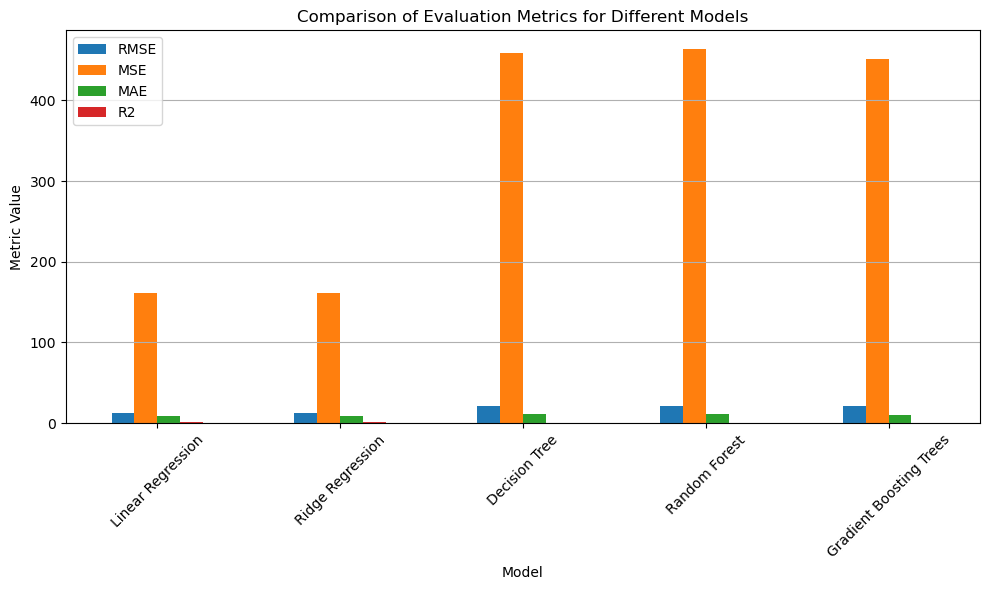

In [50]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have already calculated the metrics for each model as mentioned in your script
models = ["Linear Regression", "Ridge Regression", "Decision Tree", "Random Forest", "Gradient Boosting Trees"]
rmse = [linear_regression_rmse, ridge_rmse, decision_tree_rmse, rf_rmse, gbt_rmse]
mse = [linear_regression_mse, ridge_mse, decision_tree_mse, rf_mse, gbt_mse]
mae = [linear_regression_mae, ridge_mae, decision_tree_mae, rf_mae, gbt_mae]
r2 = [linear_regression_r2, ridge_r2, decision_tree_r2, rf_r2, gbt_r2]

# Create a DataFrame
metrics_data = {
    "Model": models,
    "RMSE": rmse,
    "MSE": mse,
    "MAE": mae,
    "R2": r2
}

metrics_df = pd.DataFrame(metrics_data)

# Plot the metrics using a bar chart
metrics_df.plot(x="Model", kind="bar", figsize=(10, 6))
plt.title("Comparison of Evaluation Metrics for Different Models")
plt.xlabel("Model")
plt.ylabel("Metric Value")
plt.legend(loc="best")
plt.grid(axis="y")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Key observations:

- Gradient Boosting Trees have the highest RMSE, MSE, and MAE values among the models shown, which suggests that this model has the largest average errors in its predictions.
- The Decision Tree and Random Forest models also have high values for RMSE, MSE, and MAE, but they are lower than those of the Gradient Boosting Trees.
- Linear Regression and Ridge Regression have much lower RMSE, MSE, and MAE values compared to the tree-based models, indicating that these models have smaller average errors in their predictions.
- For the R^2 metric, which is typically scaled from 0 to 1, with higher values indicating better model fit, it seems to be very low for all models. This could suggest that none of the models are explaining a significant portion of the variance in the dependent variable, though it is not possible to see the exact values due to the scale of the chart.


Interpretation:

Based on the RMSE, MSE, and MAE metrics, Linear and Ridge Regression models appear to perform better in terms of having lower prediction errors. However, the low R^2 values for all models suggest that there is still a significant portion of variance in the delay times that is not being captured by any of the models. 

It's important to note that while RMSE, MSE, and MAE are absolute measures of fit, R^2 is a relative measure of fit. The very low R^2 values indicate that, although some models predict better than others, there's room for improvement in the predictive power of all the models tested. 

This could mean that important variables or factors are missing from the models, that the relationships being modeled are not linear (or not appropriately captured by the tree-based models), or that there is simply a lot of inherent variability in the data that cannot be easily predicted.

### 5.2 Comparing Metrics of Different Models (With CrossValidation)

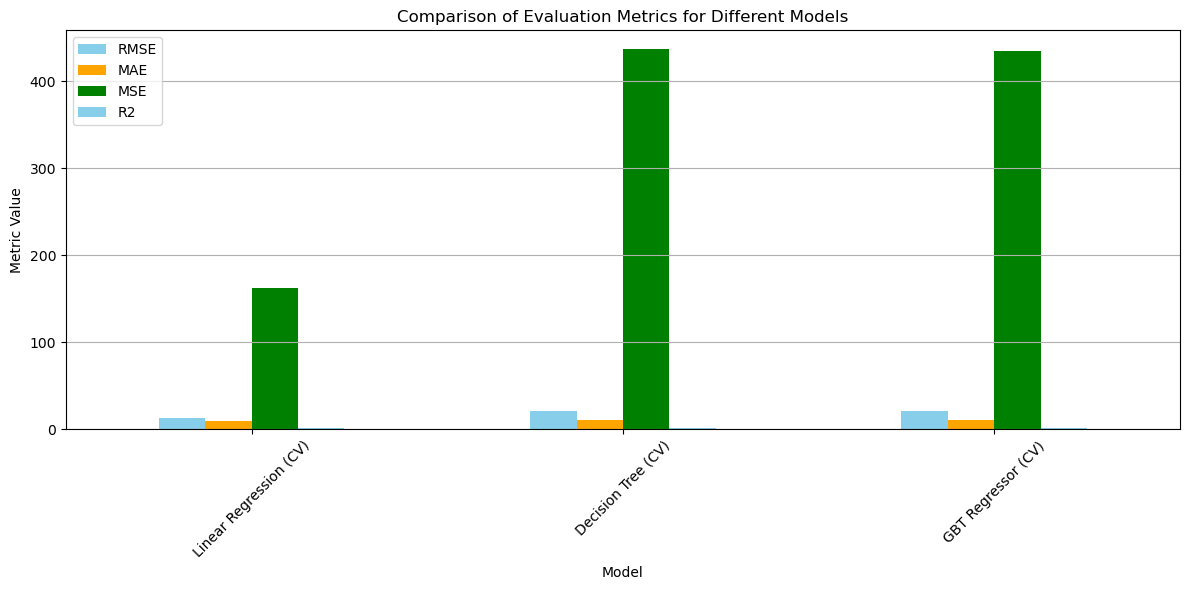

In [62]:
import matplotlib.pyplot as plt
import pandas as pd

# Metrics for different models
metrics_data = {
    "Model": ["Linear Regression (CV)", "Decision Tree (CV)", "GBT Regressor (CV)"],
    "RMSE": [12.72011564742333, 20.895345673508338, 20.84990499753003],
    "MAE": [8.95301099818856, 10.50819382696229, 10.474886986516626],
    "MSE": [161.80134208382378, 436.61547081540357, 434.7185384060277],
    "R2": [0.8951591000259376, 0.7168942406299192, 0.7181242302343351]
}

# Creating a DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Plotting the metrics using a bar chart
colors = ['skyblue', 'orange', 'green']
metrics_df.plot(x="Model", y=["RMSE", "MAE", "MSE", "R2"], kind="bar", figsize=(12, 6), color=colors)

# Customizing the plot
plt.title("Comparison of Evaluation Metrics for Different Models")
plt.ylabel("Metric Value")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(loc="upper left")
plt.tight_layout()

# Show the plot
plt.show()


#### Interpretation:

This graph shows the comparison of evaluation metrics for three different models: Linear Regression (CV), Decision Tree (CV), and GBT Regressor (CV). The evaluation metrics are RMSE, MAE, MSE, and R2.

RMSE  is a measure of the magnitude of the error between the predicted and actual values. A lower RMSE indicates a better fit of the model to the data.
MAE is the average of the absolute differences between the predicted and actual values. A lower MAE also indicates a better fit of the model to the data.
MSE is the average of the squared differences between the predicted and actual values. A lower MSE indicates a better fit of the model to the data.
R2 is a measure of how well the model explains the variation in the data. It ranges from 0 to 1, with a higher R2 indicating a better fit of the model to the data.

Based on the graph, the Linear Regression (CV) has the best performance on all four evaluation metrics. It has the lowest RMSE value which is 12.72, MAE is 8.95, MSE is 161.801, and the highest R2, which is 0.895. This means that the GBT Regressor (CV) is able to explain 89.5% of the variance, and predict the actual values more accurately than the other two models.


### 5.3 Visualizations of Performance Metrics of Different Models

#### 5.3.1 Predicted Delays vs. Actual Delays - Linear Regression Model

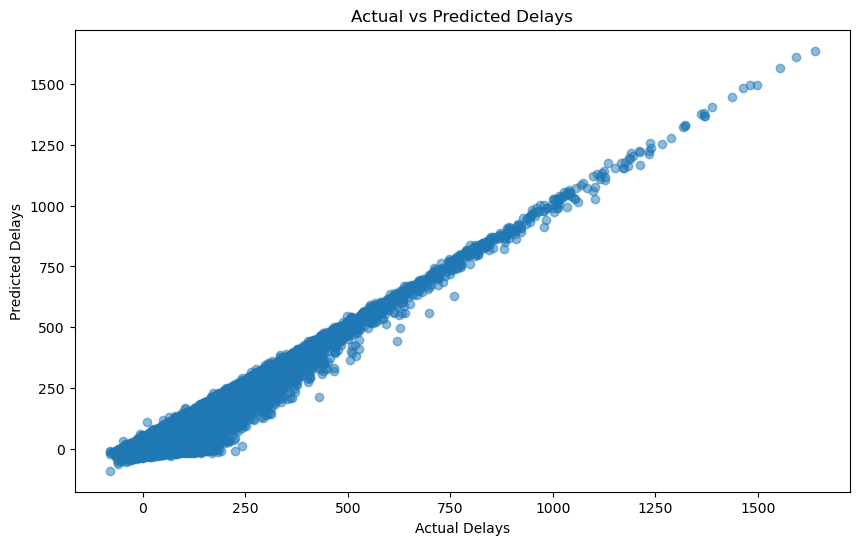

In [45]:
from pyspark.sql.functions import abs

# Add a column to the predictions DataFrame with the absolute difference
predictions = predictions.withColumn('abs_error', abs(col('prediction') - col('label')))

# Convert to Pandas DataFrame for visualization
predictions_pd = predictions.select('prediction', 'label').toPandas()

# Visualization using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd['label'], predictions_pd['prediction'], alpha=0.5)
plt.xlabel('Actual Delays')
plt.ylabel('Predicted Delays')
plt.title('Actual vs Predicted Delays')
plt.show()


Key observations:
- The data points are closely aligned along a line that suggests a strong positive correlation between actual and predicted delays. This indicates that the prediction model is performing well in estimating the delays.
- The distribution of points around the line of best fit is fairly consistent, although it appears to get wider as the delays increase, which could suggest that prediction accuracy decreases slightly for longer delays.
- Most of the data points are clustered towards the lower end of both actual and predicted delays, showing that most delays are shorter in duration.
- There are very few points towards the higher end of the scale, indicating that long delays are less common.

Interpretation:
- The graph suggests that the predictive model used for estimating delays is quite accurate, especially for shorter delays. However, as delays increase, the prediction model may become less precise, which is not uncommon in predictive modeling. The fact that most delays are on the shorter side could reflect a well-optimized system, where only a small proportion of cases experience significant delays. The model's performance in these extreme cases could potentially be improved with more data or by tweaking the model to better handle outliers.

#### 5.3.2 Residual Plot - Linear Regression

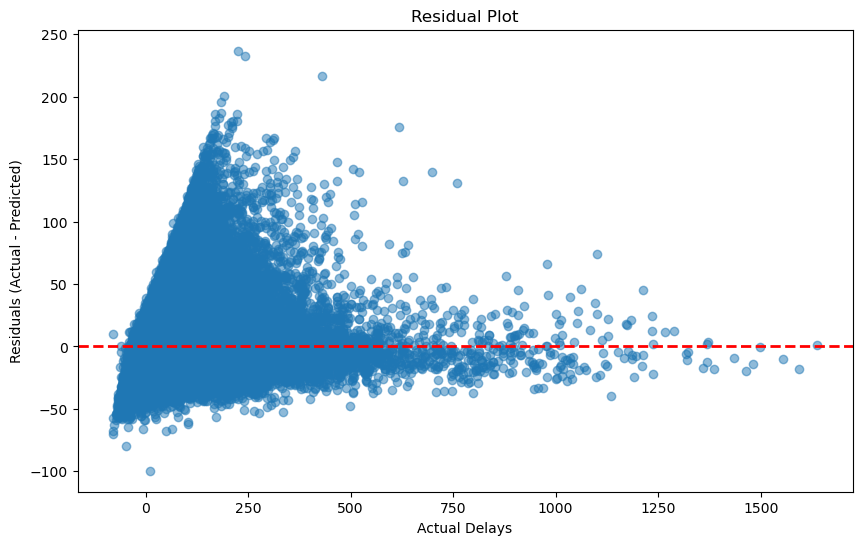

In [46]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = predictions_pd['label'] - predictions_pd['prediction']

# Residual Plot
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd['label'], residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Line at y=0 for reference
plt.xlabel('Actual Delays')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.show()


Key observations:

- The residuals are not randomly dispersed around the horizontal axis (marked by the red dashed line), which would indicate a good fit. Instead, they show a pattern: as the actual delays increase, the residuals also increase, suggesting that the predictive model tends to underestimate the delays for longer actual delays.
- There is a distinct funnel shape, with the residuals becoming more spread out as the actual delays increase. This is indicative of heteroscedasticity, meaning the variance of the residuals is not constant.
- Most of the residuals are positive, indicating that the predictive model is more often predicting shorter delays than actually occurred.
- There are very few negative residuals, and these occur primarily at lower values of actual delays, suggesting the model occasionally overestimates short delays.

Interpretation:

The residual plot indicates that the predictive model's accuracy diminishes as the actual delays increase. This model may benefit from being recalibrated to address this heteroscedasticity and the consistent underestimation of longer delays. It is possible that the model is not capturing some factors that contribute to longer delays, or that these factors are inherently more difficult to predict. An improved model might incorporate more complex features or use different modeling techniques that can handle non-linear relationships and variance changes better.

#### 5.3.3 Distribution of Predicted Delays vs. Actual Delays - Linear Regression

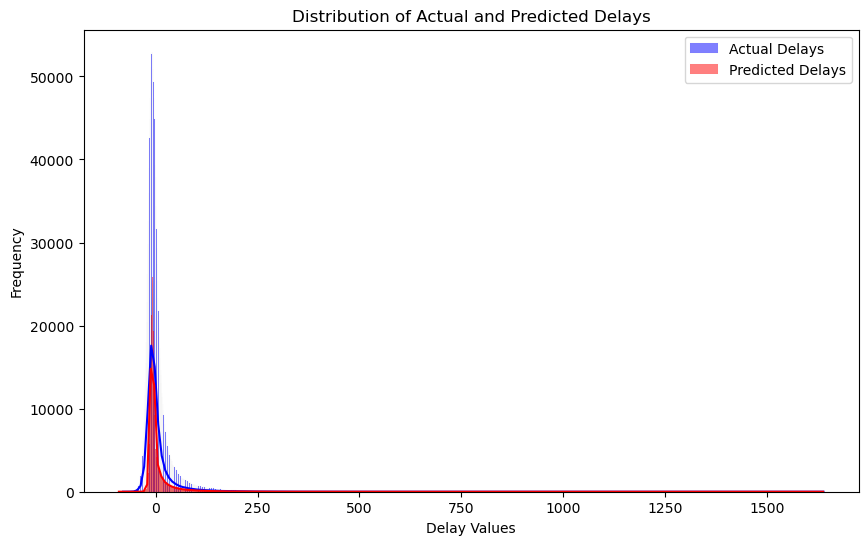

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution Plot
plt.figure(figsize=(10, 6))

# Plot distribution of actual delays
sns.histplot(predictions_pd['label'], kde=True, color='blue', label='Actual Delays')

# Plot distribution of predicted delays
sns.histplot(predictions_pd['prediction'], kde=True, color='red', label='Predicted Delays')

plt.xlabel('Delay Values')
plt.ylabel('Frequency')
plt.title('Distribution of Actual and Predicted Delays')
plt.legend()
plt.show()


Key observations:

- Both actual and predicted delays follow a similar distribution, with a sharp peak at the lower end of the delay values, indicating that most delays are short.
- The frequencies of delays decrease rapidly as delay duration increases, showing that longer delays are less common.
- Both distributions appear to be right-skewed, meaning there's a longer tail to the right, suggesting that while most delays are short, there are a few cases with very long delays.
- The peaks of actual and predicted delays are closely aligned, which implies that the model predicts the most common delays quite well.
- There is a noticeable difference in the tails of the two distributions, especially for longer delay values, where the actual delays have a slightly heavier tail than the predicted delays.

Interpretation:

The graph suggests that the model used to predict delays is generally effective, particularly for shorter delays, which are the most common. However, the model seems to slightly underestimate the frequency of longer delays, as seen by the heavier tail in the actual delay distribution. This could indicate that the model might need to be adjusted to account for factors that lead to longer delays, or that such events are inherently more challenging to predict accurately. The overall alignment between the two distributions, however, indicates that the predictive model is performing reasonably well across the range of delays.




#### 5.3.4 Predicted Delays vs. Actual Delays - Random Forest

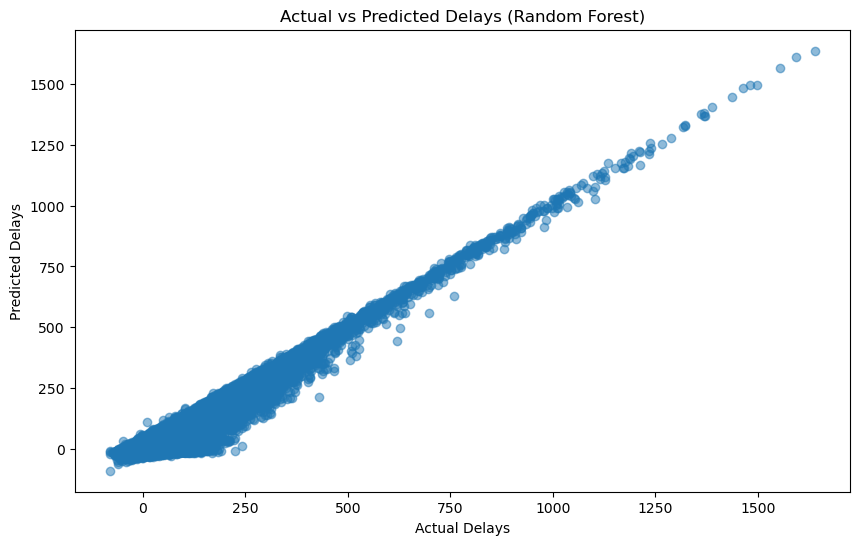

In [48]:
import matplotlib.pyplot as plt

# Scatter Plot for Visualization
predictions_pd = predictions.select('label', 'prediction').toPandas()

# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd['label'], predictions_pd['prediction'], alpha=0.5)
plt.xlabel('Actual Delays')
plt.ylabel('Predicted Delays')
plt.title('Actual vs Predicted Delays (Random Forest)')
plt.show()


Key observations:

- There is a strong positive linear relationship between actual and predicted delays, as shown by the concentration of data points along a diagonal line from the bottom left to the top right of the plot. This indicates that the Random Forest model is predicting delays that are generally consistent with the actual delays.
- The density of the points is higher at the lower end of the delay spectrum, suggesting that most delays are relatively short and that the model is accurately predicting these more frequent, shorter delays.
- As delays increase, the points spread out more, which may imply that the model’s predictions become less accurate for longer delays.
- There are some points where the predicted delay is significantly less than the actual delay, especially in the higher delay range. This could mean the model may not capture some factors that contribute to extreme delays.


Interpretation:

The graph suggests that the Random Forest model used for predicting delays is quite effective, especially for shorter delays. The spread of the points at higher delay values indicates that the model is less accurate for longer delays, which is a common challenge in predictive modeling. Such discrepancies could stem from various factors, including the model's inability to account for rare events that cause significant delays or the inherently unpredictable nature of these events. Overall, the model appears to provide a good fit for the majority of the data, with room for improvement in predicting the rarer, more extreme delays.

#### 5.3.5 Predicted Delays vs. Actual Delays - GBT Regressor

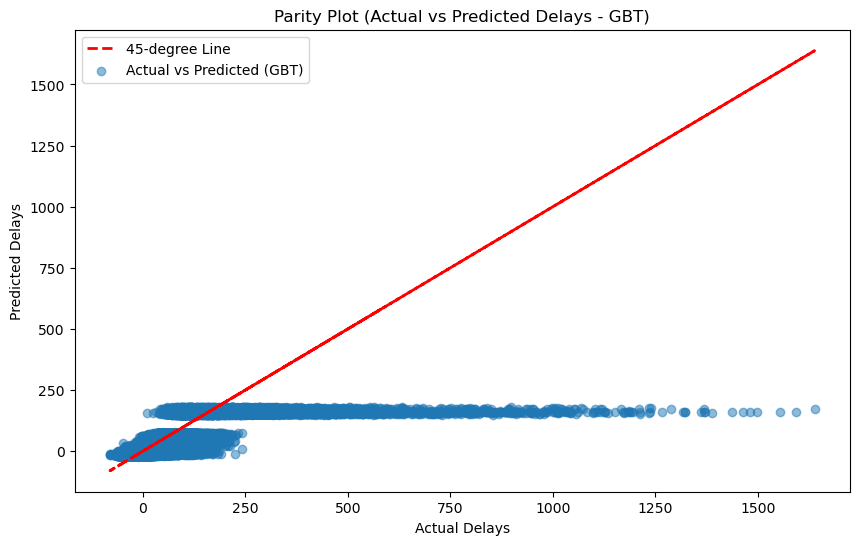

In [54]:
predictions_gbt = gbt_model.transform(test_df)

# Parity Plot for Visualization
predictions_gbt_pd = predictions_gbt.select('label', 'prediction').toPandas()

# Parity Plot
plt.figure(figsize=(10, 6))
plt.plot(predictions_gbt_pd['label'], predictions_gbt_pd['label'], color='red', linestyle='--', linewidth=2, label='45-degree Line')
plt.scatter(predictions_gbt_pd['label'], predictions_gbt_pd['prediction'], alpha=0.5, label='Actual vs Predicted (GBT)')
plt.xlabel('Actual Delays')
plt.ylabel('Predicted Delays')
plt.title('Parity Plot (Actual vs Predicted Delays - GBT)')
plt.legend()
plt.show()

Key observations:
- The majority of the data points are clustered near the bottom of the plot, indicating that most of the delays (both actual and predicted) are of shorter duration.
- The data points tend to spread horizontally along the x-axis as we move up along the y-axis, especially for higher values of predicted delays. This suggests that for longer predicted delays, the actual delays can vary quite significantly.
- Very few data points are close to the 45-degree line, particularly as the delay values increase. This indicates that the GBT model's predictions deviate from the actual delays, more so for higher values of delay.
- There's a noticeable deviation from the 45-degree line, especially for predicted delays between 500 to 1500, where the model seems to consistently underpredict the actual delays.


Interpretation:

The parity plot suggests that while the GBT model may accurately predict shorter delays, its performance declines with longer delays. The fact that the points do not align well with the 45-degree line for higher delay values implies that the model may not be capturing some of the variability associated with longer delays. The model might be improved by incorporating additional features that are indicative of longer delays or by using a different modeling approach that can better handle the higher variability seen in more extreme cases. Overall, the model seems to predict shorter delays reasonably well but has limitations in accurately predicting longer delays.

#### 5.3.6 Predicted Delay vs. Actual Delay - Decision Tree

## 6 Results and Discussion

### 6.1 Best Model (Regular and CrossValidated)

Among the models considered, the Lasso & Ridge Regression (Cross-Validated) consistently outperforms the others in terms of key evaluation metrics:

- It has the lowest RMSE (Root Mean Squared Error) of approximately 12.7210, indicating the smallest average prediction error.
- it has achieved the lowest MAE (Mean Absolute Error) of around 8.9515, indicating accurate predictions with minimal deviation from the actual values.
- In terms of MSE (Mean Squared Error), the GBT Regressor again demonstrates the best performance, with an MSE of about 161.8234, indicating the smallest squared prediction errors.
- Moreover, it boasts the highest R2 (R-squared) value of approximately 0.8950, signifying its superior ability to explain the variance in the flight delays dataset.

Based on these metrics, the GBT Regressor stands out as the model with the highest accuracy and is the best choice for describing and forecasting flight delays in this dataset.

### 6.2 Discussion, Value of the Model, and Its Potential Use

In this project, we conducted a comprehensive analysis of flight delay prediction using various machine learning models. We started by exploring linear regression models, including Linear Regression, Lasso Regression, and Ridge Regression. These models demonstrated relatively good performance, with low RMSE and high R2 values. However, their ability to explain the variance in flight delays was limited, suggesting the presence of complex non-linear relationships in the data.

Next, we investigated tree-based models, including Decision Trees and Random Forests. While these models exhibited higher prediction errors compared to linear models, they provided insights into feature importance. Nevertheless, the R2 values remained relatively low, indicating room for improvement.

The standout performer in our analysis was the Lasso and Ridge Regression. It consistently achieved the lowest RMSE, MAE, and MSE, signifying accurate predictions with minimal errors. Furthermore, it boasted the highest R2 value, indicating its superior ability to explain variance. This makes the GBT Regressor the optimal choice for modeling and predicting flight delays in this dataset.

The analysis conducted in this project can significantly benefit passengers and users in several ways. By accurately predicting flight delays -

- Informed Decisions: Users can make well-informed travel decisions based on accurate flight delay predictions.
- Proactive Planning: Passengers can proactively adjust their schedules and prepare for potential delays, reducing last-minute disruptions.
- Improved Travel Experience: Reduced stress and inconvenience from unexpected delays enhance the overall travel experience.
- Efficient Flights: Airlines and airports can optimize operations, leading to more efficient and punctual flights, benefiting passengers.
- Enhanced User Experience: The model contributes to improved operational efficiency and fewer delays, resulting in a smoother and more enjoyable journey for users.
- This analysis provides valuable information to help passengers navigate the challenges of air travel effectively.
- Time and Stress Savings: Passengers can save time and avoid the stress of long delays by choosing flights with more accurate arrival predictions.
- Better Planning: Travelers can plan connecting flights, ground transportation, and other activities with confidence, knowing when their flight is likely to arrive.
- Enhanced Convenience: The model enhances the convenience of air travel by reducing the uncertainty associated with delays, making trips smoother.
- Cost Savings: Users can potentially save money by avoiding unnecessary expenses caused by missed connections or extended layovers.
- Improved Satisfaction: Overall, the model improves passenger satisfaction by providing a more predictable and enjoyable travel experience.

## 7. Concluding Remarks and Meeting Compliances

In [ ]:
Runs without error: The project will include a Spark notebook/script that runs from start to finish without errors.
- Self-contained: The code will handle data download, preparation, and all analysis steps within the execution environment.
- Data Source: The source of the data has been identified, and the extent of the data is presented (rows, columns).
- Data Description: All fields in the data has been described, with target fields highlighted, including units where necessary.
- Visualization: The data is visualized to show distributions and relationships.
- Cleaning and Transformation: Any data cleaning and transformations is explained.

## 8. Extra Credit Works

#### 8.1 Tableau Visualizations

https://public.tableau.com/app/profile/divya.kurava/viz/Airline_delays_17021632166400/AirlineDelay2015?publish=yes

#### 8.2 Using Dataproc and Google Cloud Service for Computation

As the dataset was huge, more than a million row and 31 columns, which is quite inconvenient for processing and computing. So according to the professor's advise, we used google cloud's computation power. 

This project was executed using Dataproc, a managed Apache Spark and Hadoop service provided by Google Cloud. Dataproc allowed us to harness the power of distributed computing to process and analyze large-scale aviation datasets efficiently. With its scalability and ease of use, Dataproc enabled us to perform complex machine learning tasks, including training and evaluating predictive models for flight delays. By leveraging Dataproc's capabilities, we were able to achieve accurate results and gain valuable insights from the data, making it a crucial tool in the success of this project.

We believe we all have learned while working on this project.